# Deep Otello AI

The game reversi is a very good game to apply deep learning methods to.

Othello, also known as reversi, is a board game first published in 1883 by either Lewis Waterman or John W. Mollet in England (each one was denouncing the other as fraud).
It is a strict turn-based zero-sum game with a clear Markov chain and no hidden states, unlike card games with an unknown distribution of cards or unknown player allegiance.
The game is played with one set of stones with two colors, which is much easier to abstract than chess with its 6 unique pieces.
The game board is symmetrical and allows for playing with rotating the state around an axis or flipping/mirroring the board, which can allow for a breaking of sequences or interesting ANN architectures, quadruple the data generation by simulation, or interesting test cases where symmetry in turns should be observable if the AI reaches an "objective" policy.

## The game rules

Othello is a turn-based, two-player board game played on an 8 x 8 board, with a similar geometry to a chess game. The game pieces are black on one side and white on the other.

![Othello game board example](reversi_example.png)

The players take turns placing their stones on the board, and the objective is to surround the opponent's stones with your own stones. A player can only place a stone when it surrounds at least one of the opponent's stones with their own stones, either horizontally, vertically, or diagonally. When a player places a stone, all the surrounded stones will flip to become the player's color. If a player cannot make a move, they are skipped. The game ends when both players cannot make any more moves. The player with the most stones on the board wins, and any unclaimed fields go to the player with the most stones of their color on the board. The game starts with four stones placed in the center of the board, with each player getting two, which are placed diagonally opposite to each other.


<img alt="Startaufstellung.png" src="Startaufstellung.png"/>

## Some common Othello strategies

The placement of stones on the board is always a careful balance of attack and defense. Occupying large homogeneous stretches on the board can make it easier for the opponent to attack. The board's corners provide safety, from which occupied territory is impossible to lose, but they are difficult to obtain. The enemy must be forced to allow reaching the corners or calculate the cost of giving a stable base to the opponent. Some Othello computer strategies implement greedy algorithms based on a modified score for each field. Different values serve as score modifiers for a traditional greedy algorithm. When a player's stone captures a field, the score reached is multiplied by the modifier. The total score is the score reached by the player minus the score of the opponent. The scores change during the game and converge towards one, which gives some indications of what to expect from an Othello AI.

<img alt="ComputerPossitionScore" src="computer-score.png"/>


## Initial design decisions

At the beginning of this project, I made some design decisions. The first one was that I did not want to use a gym library because it limits the data formats accessible. I chose to implement the whole game as an entry in a stack of NumPy arrays to be able to accommodate interfacing with a neural network easier and to use SciPy pattern recognition tools to implement some game mechanics for a fast simulation cycle. In the array format, stones from the player are marked as 1, and stones by the enemy are marked as -1. I chose to ignore player colors as far as I could; instead, a player perspective was used, which allowed changing the perspective with a flipping of the sign (multiplying with -1). The array format should also allow for data multiplication or the breaking of strict sequences by flipping the game along one of the four axes (horizontal, vertical, transpose along both diagonals).

I wanted to implement different agents as classes that act on those game stacks. Since computation time is critical, all computational results are saved. The analysis of those is then repeated in real-time. If a recalculation of such a section is required, the save file can be deleted, and the code should be executed again.


In [1]:
%load_ext blackcellmagic
%load_ext line_profiler
%load_ext memory_profiler

## Imports and dependencies

The following direct dependencies where used for this project:
```toml
jupyter = "^1.0.0"
matplotlib = "^3.6.3"
numpy = "^1.24.1"
pytest = "^7.2.1"
python = "3.10.*"
scipy = "^1.10.0"
tqdm = "^4.64.1"
jupyterlab = "^3.6.1"
torchvision = "^0.14.1"
torchaudio = "^0.13.1"
```
* `Jupyter` and `jupyterlab` on pycharm was used as an IDE / Ipython was used to implement this code.
* `matplotlib` was used for visualisation and statistics.
* `numpy` was used for array support and mathematical functions
* `tqdm` was used for progress bars
* `scipy` contains fast pattern recognition tools for images. It was used to make an initial estimation about where possible turns should be.
* `torch` supplied the ANN functionalities.

In [2]:
import pickle
import abc
import itertools
import os.path
from abc import ABC
from enum import Enum
from typing import Final
from IPython.display import clear_output, display
from pathlib import Path
import glob
import copy
from functools import lru_cache, wraps

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.nn import functional
from ipywidgets import interact
from scipy.ndimage import binary_dilation
from tqdm.notebook import tqdm

## Constants

Some general constants needed to be defined. Such as board game size and Player and Enemy representations. Also, directional offsets and the initial placement of blocks.

In [3]:
BOARD_SIZE: Final[int] = 8  # defines the board side length as 8
PLAYER: Final[int] = 1  # defines the number symbolising the player as 1
ENEMY: Final[int] = -1  # defines the number symbolising the enemy as -1
EXAMPLE_STACK_SIZE: Final[int] = 1000  # defines the game stack size for examples
IMPOSSIBLE: Final[np.ndarray] = np.array([-1, -1], dtype=int)
IMPOSSIBLE.setflags(write=False)
SIMULATE_TURNS: Final[int] = 70
VERIFY_POLICY: Final[bool] = False
TRAINING_RESULT_PATH: Final[Path] = Path("training_data")
if not os.path.exists(TRAINING_RESULT_PATH):
    os.mkdir(TRAINING_RESULT_PATH)

The directions array contains all the numerical offsets needed to move along one of the 8 directions in a two-dimensional grid. This will allow an iteration over the game board.

![8-directions.png](8-directions.png "Offset in 8 directions")

In [4]:
DIRECTIONS: Final[np.ndarray] = np.array(
    [[i, j] for i in range(-1, 2) for j in range(-1, 2) if j != 0 or i != 0],
    dtype=int,
)
DIRECTIONS.setflags(write=False)
DIRECTIONS

array([[-1, -1],
       [-1,  0],
       [-1,  1],
       [ 0, -1],
       [ 0,  1],
       [ 1, -1],
       [ 1,  0],
       [ 1,  1]])

Another constant needed is the initial start square at the center of the board.

In [5]:
START_SQUARE: Final[np.ndarray] = np.array(
    [[ENEMY, PLAYER], [PLAYER, ENEMY]], dtype=int
)
START_SQUARE.setflags(write=False)
START_SQUARE

array([[-1,  1],
       [ 1, -1]])

## Creating new boards

The first function implemented and tested is a function to generate the starting environment as a stack of games.
As described above I simply placed a 2 by 2 square in the center of an empty stack of boards.

In [6]:
def get_new_games(number_of_games: int) -> np.ndarray:
    """Generates a stack of initialised game boards.

    Args:
        number_of_games: The size of the board stack.

    Returns: The generates stack of games as a stack n x 8 x 8.

    """
    empty = np.zeros([number_of_games, BOARD_SIZE, BOARD_SIZE], dtype=int)
    empty[:, 3:5, 3:5] = START_SQUARE
    return empty


get_new_games(1)[0]

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  1,  0,  0,  0],
       [ 0,  0,  0,  1, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [7]:
test_number_of_games = 3
assert get_new_games(test_number_of_games).shape == (
    test_number_of_games,
    BOARD_SIZE,
    BOARD_SIZE,
)
np.testing.assert_equal(
    get_new_games(test_number_of_games).sum(axis=1),
    np.zeros(
        [
            test_number_of_games,
            8,
        ]
    ),
)
np.testing.assert_equal(
    get_new_games(test_number_of_games).sum(axis=2),
    np.zeros(
        [
            test_number_of_games,
            8,
        ]
    ),
)
assert np.all(get_new_games(test_number_of_games)[:, 3:4, 3:4] != 0)
del test_number_of_games

## Visualisation tools

In this section a visualisation help was implemented for debugging of the game and a proper display of the results.
For this visualisation ChatGPT was used as a prompted code generator that was later reviewed and refactored by hand to integrate seamlessly into the project as a whole.
White stones represent the player, black stones the enemy. A single plot can be used as a subplot when the `ax` argument is used.

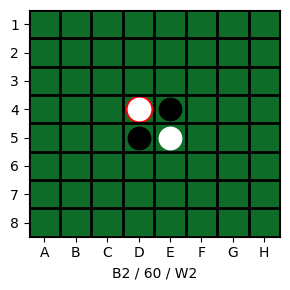

In [219]:
def plot_othello_board(
    board: np.ndarray | torch.Tensor,
    action: np.ndarray | None = None,
    score: float | None = None,
    ax=None,
) -> None:
    """Plots a single otello board.

    If a matplot axis object is given the board will be plotted into that axis. If not an axis object will be generated.
    The image generated will be shown directly.

    Args:
        board: The bord that should be plotted. Only a single games is allowed. A numpy array of the form 8x8 is expected.
        action: The action taken on each board.
        score: The score reached with the turn.
        ax: If needed a matplotlib axis object can be defined that is used to place the board as a sublot into a bigger context.
    """
    # convert a tensor into an array
    if isinstance(board, torch.Tensor):
        board = board.cpu().detach().numpy()

    # ensure the shape of the array fits
    assert board.shape == (8, 8)
    plot_all = False

    # create a figure if no axis is given
    if ax is None:
        fig_size = 3
        plot_all = True
        fig, ax = plt.subplots(figsize=(fig_size, fig_size))

    # set the background color
    ax.set_facecolor("#0f6b28")

    # plot the actions
    if action is not None:
        ax.scatter(action[0], action[1], s=350 if plot_all else 200, c="red")

    # plot black and white stones
    for x_pos, y_pos in itertools.product(range(BOARD_SIZE), range(BOARD_SIZE)):
        if board[x_pos, y_pos] == ENEMY:
            color = "white"
        elif board[x_pos, y_pos] == PLAYER:
            color = "black"
        else:
            continue
        ax.scatter(x_pos, y_pos, s=260 if plot_all else 140, c=color)

    # plot the lines separating the fields
    for x_pos in range(-1, 8):
        ax.axhline(x_pos + 0.5, color="black", lw=2)
        ax.axvline(x_pos + 0.5, color="black", lw=2)

    # define the size of the plot
    ax.set_xlim(-0.5, 7.5)
    ax.set_ylim(7.5, -0.5)

    # set the axis labels
    ax.set_xticks(np.arange(8))
    ax.set_xticklabels(list("ABCDEFGH"))
    ax.set_yticks(np.arange(8))
    ax.set_yticklabels(list("12345678"))

    # overrides the x_label text if a score should be plotted
    if score is None:
        ax.set_xlabel(
            f"B{np.sum(board == PLAYER)} / {np.sum(board == 0)} / W{np.sum(board == ENEMY)}"
        )
    else:
        ax.set_xlabel(f"Score: {score}")
    if plot_all:
        plt.tight_layout()


plot_othello_board(get_new_games(1)[0], action=np.array([3, 3]))

In [9]:
PLOTS_PER_ROW = 4


def plot_othello_boards(
    boards: np.ndarray,
    actions: np.ndarray | None = None,
    scores: np.ndarray | None = None,
) -> None:
    """Plots multiple boards into subplots.

    The plots are shown directly.

    Args:
        boards: Plots the boards given into subplots. The maximum number of boards accepted is 70.
        actions: A list of actions taken on each of the boards.
        scores: A list of scores reached at each board.
    """
    # checking if the array input shapes do fit
    assert len(boards.shape) == 3
    assert boards.shape[1:] == (BOARD_SIZE, BOARD_SIZE)
    assert boards.shape[0] < 70

    if actions is not None:
        assert len(actions.shape) == 2
        assert actions.shape[1] == 2
        assert boards.shape[0] == actions.shape[0]

    if scores is not None:
        assert len(scores.shape) == 1
        assert boards.shape[0] == scores.shape[0]

    # plots the boards
    rows = int(np.ceil(boards.shape[0] / PLOTS_PER_ROW))
    fig, axs = plt.subplots(rows, PLOTS_PER_ROW, figsize=(12, 3 * rows))
    for game_index, ax in enumerate(axs.flatten()):
        if game_index >= boards.shape[0]:
            fig.delaxes(ax)
        else:
            action = actions[game_index] if actions is not None else None
            score = scores[game_index] if scores is not None else None
            plot_othello_board(boards[game_index], action=action, score=score, ax=ax)
    plt.tight_layout()
    plt.show()

In [10]:
def drop_duplicate_boards(
    boards: np.ndarray,
    actions: np.ndarray | None,
) -> tuple[np.ndarray, np.ndarray | None]:
    """Takes a sequence of boards and drops all boards that are unchanged.

    Args:
        boards: A list of boards to be reduced.
        actions: A list of actions to be reduced alongside the bords.

    Returns:
        A sequence of boards where boards that where equal are dropped.
    """
    non_duplicates = ~np.all(boards == np.roll(boards, axis=0, shift=1), axis=(1, 2))
    return (
        boards[non_duplicates],
        np.roll(actions, axis=0, shift=1)[non_duplicates]
        if actions is not None
        else None,
    )

## Hash Otello Boards

A challenge for training any reinforcement learning algorithm is how to properly calibrate the exploration rate.
To make huge numbers of boards comparable it is easier to work with hashes than with the actual boards. For that purpose a functionality to hash a board and a stack of boards was added.

In [11]:
def hash_board(board: np.ndarray) -> int:
    assert board.shape == (8, 8) or board.shape == (64,)
    return hash(tuple(board.reshape(-1)))


def count_unique_boards(boards: np.ndarray) -> int:
    return np.unique(
        np.apply_along_axis(hash_board, axis=1, arr=boards.reshape(-1, 64))
    ).size


a = count_unique_boards(np.random.randint(-1, 2, size=(10_000, 8, 8)))

## Find possible actions to take

The frist step in the implementation of an AI like this is to get an overview over the possible actions that can be taken in a situation.
Here was the design choice taken to first find fields that are empty and have at least one neighbouring enemy stone.
This was implemented with element wise check for a stone and a binary dilation marking all fields neighboring an enemy stone.
For that the `SURROUNDING` mask was used. Both aries are then element wise combined using and.
The resulting array contains all filed where a turn could potentially be made. Those are then check in detail.
The previous element wise operations on the numpy array increase the spead for this operation dramatically.

The check for a possible turn is done in detail by following each direction step by step as long as there are enemy stones in that direction.
If the board end is reached or en empty filed before reaching a field occupied by the player that direction does not surround enemy stones.
If one direction surrounds enemy stone a turn is possible.
This detailed step is implemented as a recursion and need to go at leas one step to return True.

In [12]:
SURROUNDING: Final = np.array(
    [[[1, 1, 1], [1, 0, 1], [1, 1, 1]]]
)  # defines the binary dilation mask to check if a field is next to an enemy stones
SURROUNDING

array([[[1, 1, 1],
        [1, 0, 1],
        [1, 1, 1]]])

To optimize the computation of this game, the `lru_cache` decorator was utilized. LRU cache stores the hash of the arguments and returns the previously calculated result of a computationally heavy operation. However, since Numpy arrays are mutable and unhashable, a code snippet was modified to include conversion to tuples, caching layer, and reconversion to Numpy arrays. This allows for the caching to be implemented. As a result, the calculation time of possible actions to take was reduced to only 30% of the time it takes without the lru_cache decorator.

In [13]:
# Source https://gist.github.com/Susensio/61f4fee01150caaac1e10fc5f005eb75
def np_cache(*lru_args, array_argument_elements: tuple[int, ...] = (0,), **lru_kwargs):
    """
    LRU cache implementation for functions whose parameter at ``array_argument_index`` is a numpy array of dimensions <= 2

    Example:
    >>> from sem_env.utils.cache import np_cache
    >>> array = np.array([[1, 2, 3], [4, 5, 6]])
    >>> @np_cache(maxsize=256)
    ... def multiply(array, factor):
    ...     return factor * array
    >>> multiply(array, 2)
    >>> multiply(array, 2)
    >>> multiply.cache_info()
    CacheInfo(hits=1, misses=1, maxsize=256, currsize=1)
    """

    def decorator(function):
        @wraps(function)
        def wrapper(*args, **kwargs):
            args = list(args)
            for array_argument_index in array_argument_elements:
                np_array = args[array_argument_index]
                if len(np_array.shape) > 2:
                    raise RuntimeError(
                        f"np_cache is currently only supported for arrays of dim. less than 3 but got shape: {np_array.shape}"
                    )
                hashable_array = tuple(np_array.reshape(-1))

                args[array_argument_index] = hashable_array
            return cached_wrapper(*args, **kwargs)

        @lru_cache(*lru_args, **lru_kwargs)
        def cached_wrapper(*args, **kwargs):
            args = list(args)
            for array_argument_index in array_argument_elements:
                hashable_array = args[array_argument_index]
                array = np.array(hashable_array).reshape(8, 8)
                args[array_argument_index] = array
            return function(*args, **kwargs)

        # copy lru_cache attributes over too
        wrapper.cache_info = cached_wrapper.cache_info
        wrapper.cache_clear = cached_wrapper.cache_clear
        return wrapper

    return decorator

In [14]:
def _recursive_steps(
    board: np.ndarray,
    rec_direction: np.ndarray,
    rec_position: np.ndarray,
    step_one: int = 0,
) -> int:
    """Check if a player can place a stone on the board specified in the direction specified and direction specified.

    Args:
        board: The board that should be checked for a playable action.
        rec_direction: The direction that should be checked.
        rec_position: The position that should be checked.
        step_one: Defines if the call of this function is the firs or not. Should be kept to the default value for proper functionality.

    Returns:
        True if a turn is possible for possition and direction on the board defined.
    """
    rec_position = rec_position + rec_direction
    if np.any((rec_position >= BOARD_SIZE) | (rec_position < 0)):
        return 0
    next_field = board[tuple(rec_position.tolist())]
    if next_field == 0:
        return 0
    if next_field == -1:
        return _recursive_steps(
            board, rec_direction, rec_position, step_one=step_one + 1
        )
    if next_field == 1:
        return step_one


@np_cache(maxsize=2000, array_argument_elements=(0, 1))
def _get_possible_turns_for_board(
    board: np.ndarray, poss_turns: np.ndarray
) -> np.ndarray:
    """Calculates where turns are possible.

    Args:
        board: The board that should be checked for a playable action.
        poss_turns: An array of actions that could be possible. All true fields are empty and next to an enemy stone.
    """
    for idx, idy in itertools.product(range(BOARD_SIZE), range(BOARD_SIZE)):
        if poss_turns[idx, idy]:
            position = idx, idy
            poss_turns[idx, idy] = any(
                _recursive_steps(board[:, :], direction, position) > 0
                for direction in DIRECTIONS
            )
    return poss_turns


def get_possible_turns(boards: np.ndarray, tqdm_on: bool = False) -> np.ndarray:
    """Analyses a stack of boards.

    Args:
        boards: A stack of boards to check.
        tqdm_on: Uses tqdm to track the progress.

    Returns:
        A stack of game boards containing boolean values showing where turns are possible for the player.
    """
    assert len(boards.shape) == 3, "The number fo input dimensions does not fit."
    assert boards.shape[1:] == (
        BOARD_SIZE,
        BOARD_SIZE,
    ), "The input dimensions do not fit."

    poss_turns = boards == 0  # checks where fields are empty.
    poss_turns &= binary_dilation(
        boards == -1, SURROUNDING
    )  # checks where fields are next to an enemy filed an empty
    iterate_over = range(boards.shape[0])

    if tqdm_on:
        iterate_over = tqdm(iterate_over, total=np.prod(boards.shape))
    for game in iterate_over:
        poss_turns[game] = _get_possible_turns_for_board(boards[game], poss_turns[game])
    return poss_turns


# some simple testing to ensure the function works after simple changes
# this testing is complete, its more of a smoke-test
test_array = get_new_games(3)
expected_result = np.zeros_like(test_array, dtype=bool)
expected_result[:, 4, 5] = expected_result[:, 2, 3] = True
expected_result[:, 5, 4] = expected_result[:, 3, 2] = True
np.testing.assert_equal(get_possible_turns(test_array), expected_result)


%timeit get_possible_turns(get_new_games(10))  # checks turn possibility evaluation time for 10 initial games
# %timeit get_possible_turns(get_new_games(EXAMPLE_STACK_SIZE))  # check turn possibility evaluation time for EXAMPLE_STACK_SIZE initial games

# shows a singe game
get_possible_turns(get_new_games(3))[:1]

194 µs ± 9.18 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


array([[[False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False,  True, False, False, False, False],
        [False, False,  True, False, False, False, False, False],
        [False, False, False, False, False,  True, False, False],
        [False, False, False, False,  True, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False]]])

Besides the ability to generate an array of possible turns there needs to be a functions that check if a given turn is possible.
On is needed for the action space validation. The other is for validating a players turn.

In [15]:
def move_possible(board: np.ndarray, move: np.ndarray) -> bool:
    """Checks if a turn is possible.

    Checks if a turn is possible. If no turn is possible to input array [-1, -1] is expected.

    Args:
        board: A board where it should be checkt if a turn is possible.
        move: The move that should be taken. Expected is the index of the filed where a stone should be placed [x, y]. If no placement is possible [-1, -1] is expected as an input.

    Returns:
        True if the move is possible
    """
    if np.all(move == -1):
        return not np.any(get_possible_turns(np.reshape(board, (1, 8, 8))))
    return any(
        _recursive_steps(board[:, :], direction, move) > 0 for direction in DIRECTIONS
    )


# Some testing for this function and the underlying recursive functions that are called.
assert move_possible(get_new_games(1)[0], np.array([2, 3])) is True
assert move_possible(get_new_games(1)[0], np.array([3, 2])) is True
assert move_possible(get_new_games(1)[0], np.array([2, 2])) is False
assert move_possible(np.zeros((8, 8)), np.array([3, 2])) is False
assert move_possible(np.ones((8, 8)) * 1, np.array([-1, -1])) is True
assert move_possible(np.ones((8, 8)) * -1, np.array([-1, -1])) is True
assert move_possible(np.ones((8, 8)) * 0, np.array([-1, -1])) is True

In [16]:
def moves_possible(boards: np.ndarray, moves: np.ndarray) -> np.ndarray:
    """Checks if a stack of moves can be executed on a stack of boards.

    Args:
        boards: A board where the next stone should be placed.
        moves: A stack stones to be placed. Each move is formatted as an array in the form of [x, y] if no turn is possible the value [-1, -1] is expected.

    Returns:
        An array marking for each and every game and move in the stack if the move can be executed.
    """
    arr_moves_possible = np.zeros(boards.shape[0], dtype=bool)
    for game in range(boards.shape[0]):
        if np.all(
            moves[game] == -1
        ):  # can be all or any. All should be faster since most times neither value will be -1.
            arr_moves_possible[game] = not np.any(
                get_possible_turns(np.reshape(boards[game], (1, 8, 8)))
            )
        else:
            arr_moves_possible[game] = any(
                _recursive_steps(boards[game, :, :], direction, moves[game]) > 0
                for direction in DIRECTIONS
            )
    return arr_moves_possible


np.testing.assert_array_equal(
    moves_possible(np.ones((3, 8, 8)) * 1, np.array([[-1, -1]] * 3)),
    np.array([True] * 3),
)

np.testing.assert_array_equal(
    moves_possible(get_new_games(3), np.array([[2, 3], [3, 2], [3, 2]])),
    np.array([True] * 3),
)
np.testing.assert_array_equal(
    moves_possible(get_new_games(3), np.array([[2, 2], [1, 1], [0, 0]])),
    np.array([False] * 3),
)
np.testing.assert_array_equal(
    moves_possible(np.ones((3, 8, 8)) * -1, np.array([[-1, -1]] * 3)),
    np.array([True] * 3),
)
np.testing.assert_array_equal(
    moves_possible(np.zeros((3, 8, 8)), np.array([[-1, -1]] * 3)),
    np.array([True] * 3),
)

## Execute a chosen action

After an evaluation what turns are possible there needs to be a function that executes a turn.
This next sections does that.

In [17]:
class InvalidTurn(ValueError):
    """
    This error is thrown if a given turn is not valid.
    """

114 ms ± 3.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


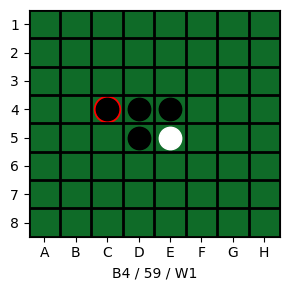

In [18]:
def do_moves(boards: np.ndarray, moves: np.ndarray) -> np.ndarray:
    """Executes a single move on a stack o Othello boards.

    Args:
        boards: A stack of Othello boards where the next stone should be placed.
        moves: A stack of stone placement orders for the game. Formatted as coordinates in an array [x, y] of the place where the stone should be placed. Should contain [-1,-1] if no new placement is possible.

    Returns:
        The new state of the board.
    """

    def _do_directional_move(
        board: np.ndarray, rec_move: np.ndarray, rev_direction, step_one=True
    ) -> bool:
        """Changes the color of enemy stones in one direction.

        This function works recursive. The argument step_one should always be used in its default value.

        Args:
            board: A bord on which a stone was placed.
            rec_move: The position on the board in x and y where this function is called from. Will be moved by recursive called.
            rev_direction: The position where the stone was placed. Inside this recursion it will also be the last step that was checked.
            step_one: Set to true if this is the first step in the recursion. False later on.

        Returns:
            True if a stone could be flipped.
            All changes are made on the view of the numpy array and therefore not included in the return value.
        """
        rec_position = rec_move + rev_direction
        if np.any((rec_position >= 8) | (rec_position < 0)):
            return False
        next_field = board[tuple(rec_position.tolist())]
        if next_field == 0:
            return False
        if next_field == 1:
            return not step_one
        if next_field == -1:
            if _do_directional_move(board, rec_position, rev_direction, step_one=False):
                board[tuple(rec_position.tolist())] = 1
                return True
            return False

    def _do_move(_board: np.ndarray, move: np.ndarray) -> None:
        """Executes a turn on a board.

        Args:
            _board: The game board on wich to place a stone.
            move: The coordinates of a stone that should be placed. Should be formatted as an array of the form [x, y]. The value [-1, -1] is expected if no turn is possible.

        Returns:
            All changes are made on the view of the numpy array.
        """
        if np.all(move == -1):
            if not move_possible(_board, move):
                raise InvalidTurn("An action should be taken. A turn is possible.")
            return

        # noinspection PyTypeChecker
        if _board[tuple(move.tolist())] != 0:
            raise InvalidTurn("This turn is not possible.")

        action = False
        for direction in DIRECTIONS:
            if _do_directional_move(_board, move, direction):
                action = True
        if not action:
            raise InvalidTurn("This turn is not possible.")

        # noinspection PyTypeChecker
        _board[tuple(move.tolist())] = 1

    boards = boards.copy()
    for game in range(boards.shape[0]):
        _do_move(boards[game], moves[game])
    return boards


%timeit do_moves(get_new_games(EXAMPLE_STACK_SIZE), np.array([[2, 3]] * EXAMPLE_STACK_SIZE))[0]

plot_othello_board(
    do_moves(
        get_new_games(EXAMPLE_STACK_SIZE), np.array([[2, 3]] * EXAMPLE_STACK_SIZE)
    )[0],
    action=np.array([2, 3]),
)

## An abstract reversi game policy

For an easy use of policies an abstract class containing the policy generation / requests an action in an inherited instance of this class.
This class filters the policy to only propose valid actions. Inherited instance do not need to care about this. This super class also manges exploration and exploitation with the epsilon value.

In [19]:
class GamePolicy(ABC):
    """
    A game policy. Proposes where to place a stone next.
    """

    def __init__(self, epsilon: float):
        """

        Args:
            epsilon: the epsilon / greedy value. Should be between zero and one. Set the mixture of policy and exploration. One means only the policy is used. Zero means only random policies are used. All mixtures inbetween between are possible.
        """
        if 0 > epsilon > 1:
            raise ValueError("Epsilon should be between zero and one.")
        self.epsilon: float = epsilon

    @property
    @abc.abstractmethod
    def policy_name(self) -> str:
        """The name of this policy"""
        raise NotImplementedError()

    @abc.abstractmethod
    def _internal_policy(self, boards: np.ndarray) -> np.ndarray:
        """The internal policy is an unfiltered policy. It should only be called from inside this function

        Args:
            boards: A board where a policy should be calculated for.

        Returns:
            The policy for this board. Should have the same size as the boards array.
        """
        raise NotImplementedError()

    def get_policy(self, boards: np.ndarray) -> np.ndarray:
        """Calculates the policy that should be followed.

        Calculates the policy that should be followed.
        This function does include the usage of epsilon to configure greediness and exploration.

        Args:
            boards: A set of boards that show the environment where the policy should be calculated for.

        Returns:
            A vector of indices. Should be formatted as an array of the form [x, y]. The value [-1, -1] is expected if no turn is possible.
        """
        assert len(boards.shape) == 3
        assert boards.shape[1:] == (BOARD_SIZE, BOARD_SIZE)

        if self.epsilon <= 0:
            policies = np.random.rand(*boards.shape)
        else:
            policies = self._internal_policy(boards)
            if self.epsilon < 1:
                random_choices = self.epsilon <= np.random.rand((boards.shape[0]))
                policies[random_choices] = np.random.rand(np.sum(random_choices), 8, 8)

        # todo possibly change this function to only validate the purpose turn and not all turns
        possible_turns = get_possible_turns(boards)
        policies[possible_turns == False] = -1.0
        max_indices = [
            np.unravel_index(policy.argmax(), policy.shape) for policy in policies
        ]
        policy_vector = np.array(max_indices, dtype=int)
        no_turn_possible = np.all(policy_vector == 0, 1) & (policies[:, 0, 0] == -1.0)

        policy_vector[no_turn_possible, :] = IMPOSSIBLE
        return policy_vector

## Some first policies

To quantify the quality of a game AI there needs to be some benchmarks.
The easiest benchmark is to play against a random player.
The easiest player to use as a benchmark is the random player.
For this and testing purpose the random policy was implemented.

In [20]:
class RandomPolicy(GamePolicy):
    """
    A policy playing a random turn by setting epsilon to 0.
    """

    def __init__(self, epsilon: float = 0):
        _ = epsilon
        super().__init__(epsilon=0)

    @property
    def policy_name(self) -> str:
        return "random"

    def _internal_policy(self, boards: np.ndarray) -> np.ndarray:
        return np.random.rand(*boards.shape)


rnd_policy = RandomPolicy(1)
assert rnd_policy.policy_name == "random"
assert rnd_policy.epsilon == 0

rnd_policy_result = rnd_policy.get_policy(get_new_games(10))
assert np.any((5 >= rnd_policy_result) & (rnd_policy_result >= 3))

An alternative benchmark policy is a greedy policy that takes always the maximum number of stones possible.

In [21]:
class GreedyPolicy(GamePolicy):
    """
    A policy playing always one of the strongest turns.
    """

    def __init__(self, epsilon: float = 1):
        _ = epsilon
        super().__init__(1)

    @property
    def policy_name(self) -> str:
        return "greedy_policy"

    def _internal_policy(self, boards: np.ndarray) -> np.ndarray:
        policies = np.random.rand(*boards.shape)
        poss_turns = boards == 0  # checks where fields are empty.
        poss_turns &= binary_dilation(boards == -1, SURROUNDING)
        for game, idx, idy in itertools.product(
            range(boards.shape[0]), range(BOARD_SIZE), range(BOARD_SIZE)
        ):

            if poss_turns[game, idx, idy]:
                position = idx, idy
                policies[game, idx, idy] += np.sum(
                    np.array(
                        list(
                            _recursive_steps(boards[game, :, :], direction, position)
                            for direction in DIRECTIONS
                        )
                    )
                )
        return policies

## Putting the game simulation together
Now it's time to bring all together for a proper simulation.

### Playing a single turn

The next function needed is used to request a policy, verify that the turn is legit and place a stone and turn enemy stones if possible.

In [22]:
def single_turn(
    current_boards: np, policy: GamePolicy
) -> tuple[np.ndarray, np.ndarray]:
    """Execute a single turn on a board.

    Places a new stone on the board. Turns captured enemy stones.

    Args:
        current_boards: The current board before the game.
        policy: The game policy to be used.

    Returns:
        The new game board and the policy vector containing the index of the action used.
    """
    policy_results = policy.get_policy(current_boards)

    # if the constant VERIFY_POLICY is set to true the policy is verified. Should be good though.
    # todo deactivate the policy verification after some testing.
    if VERIFY_POLICY:
        assert np.all(moves_possible(current_boards, policy_results)), (
            current_boards[(moves_possible(current_boards, policy_results) == False)],
            policy_results[(moves_possible(current_boards, policy_results) == False)],
            np.where(moves_possible(current_boards, policy_results) == False),
        )
    return do_moves(current_boards, policy_results), policy_results

### Simulate a stack of games
This function will simulate a stack of games and return an array of policies and histories.

This will return an arrays with the size of (70 x n x 8 x 8) and (70 x n x 2).
The first will contain the boards. The second will contain the actions. If no action is taken the action will be noted as played in (-1, -1).

In [23]:
def simulate_game(
    nr_of_games: int,
    policies: tuple[GamePolicy, GamePolicy],
    tqdm_on: bool = False,
) -> tuple[np.ndarray, np.ndarray]:
    """Simulates a stack of games.

    Args:
        nr_of_games: The number of games that should be simulated.
        policies: The policies that should be used to simulate the game.
        tqdm_on: Switches tqdm on.

    Returns:
        A stack of board histories and actions.
    """
    board_history_stack = np.zeros((SIMULATE_TURNS, nr_of_games, 8, 8), dtype=np.int8)
    action_history_stack = np.zeros((SIMULATE_TURNS, nr_of_games, 2), dtype=np.int8)
    current_boards = get_new_games(nr_of_games)
    for turn_index in tqdm(range(SIMULATE_TURNS)) if tqdm_on else range(SIMULATE_TURNS):
        policy_index = turn_index % 2
        policy = policies[policy_index]
        board_history_stack[turn_index, :, :, :] = current_boards
        if policy_index == 1:
            current_boards *= -1
        current_boards, action_taken = single_turn(current_boards, policy)
        action_history_stack[turn_index, :] = action_taken

        if policy_index == 1:
            current_boards *= -1

    return board_history_stack, action_history_stack

The first thing to do now is try out how the player act.

## Simulating games

Since now a simulator, a tool for visualisation and two policies exist a few games need to be simulated to verify proper function off all three elements.

### Random vs. random policy
First there is a simulation of a game between two random polices.

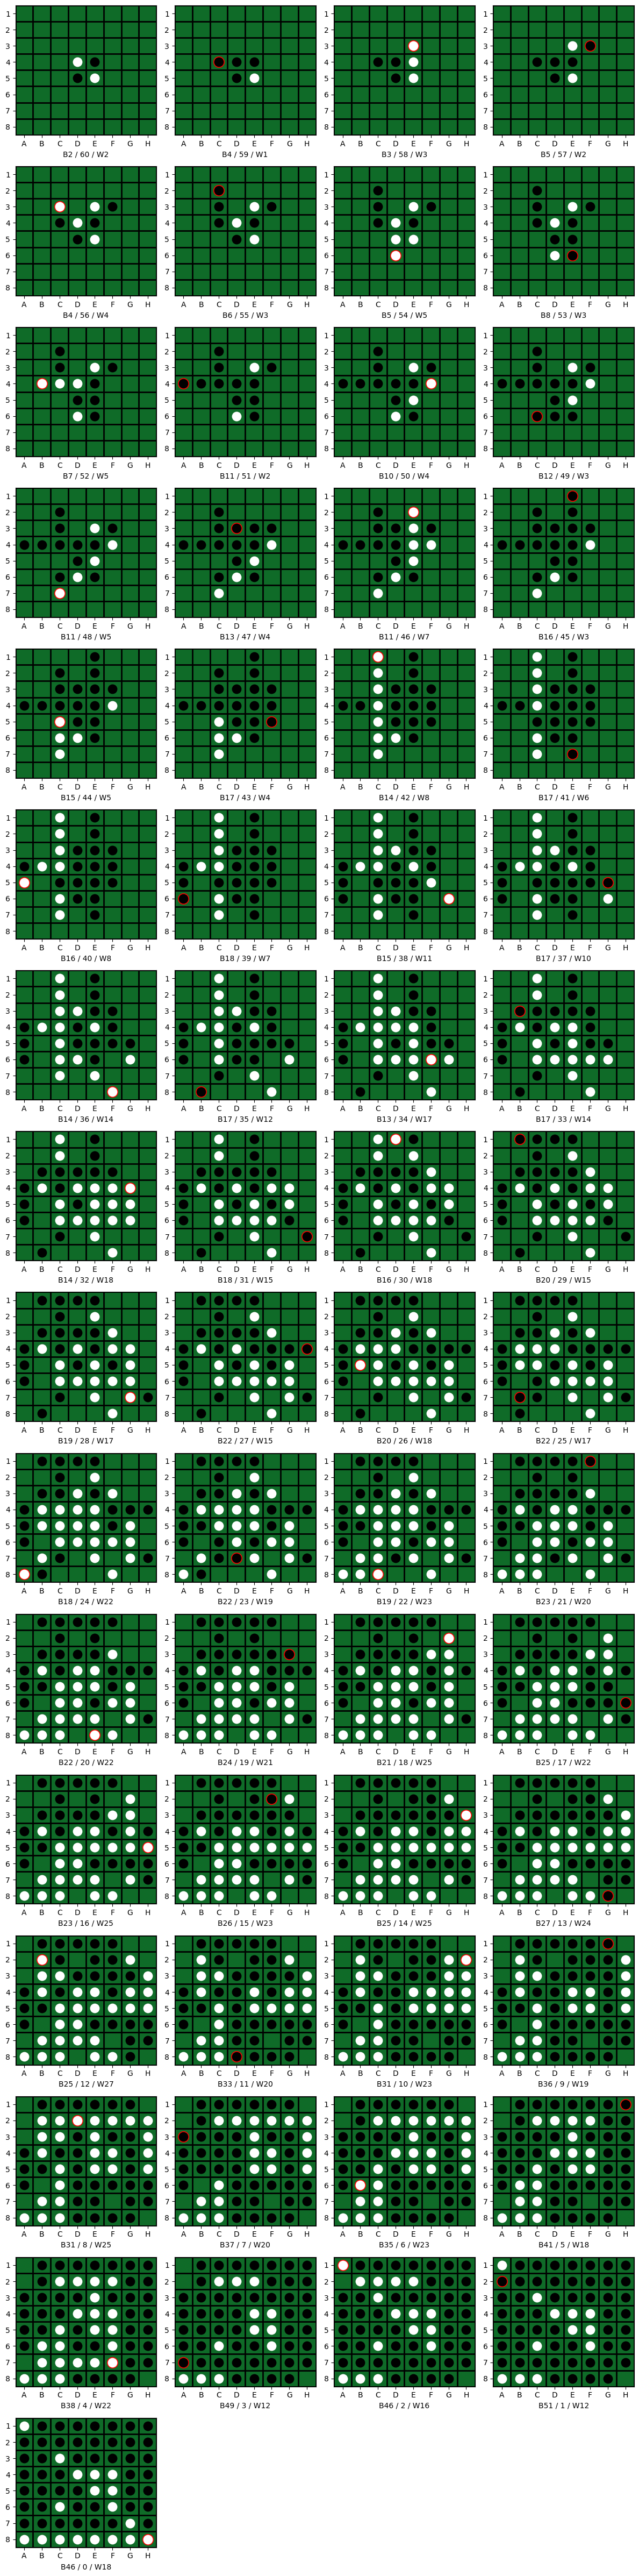

In [24]:
np.random.seed(0)
simulation_results = simulate_game(1, (RandomPolicy(1), RandomPolicy(1)))
_unique_bords, _unique_actions = drop_duplicate_boards(
    simulation_results[0].reshape(-1, 8, 8), simulation_results[1].reshape(-1, 2)
)
plot_othello_boards(_unique_bords, actions=_unique_actions)

In [25]:
%memit simulate_game(100, (RandomPolicy(1), RandomPolicy(1)))
%timeit simulate_game(100, (RandomPolicy(1), RandomPolicy(1)))

peak memory: 342.61 MiB, increment: 1.22 MiB
11.7 s ± 448 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Greedy vs. greedy policy
Then there is a simulation of a game between two greedy policies.

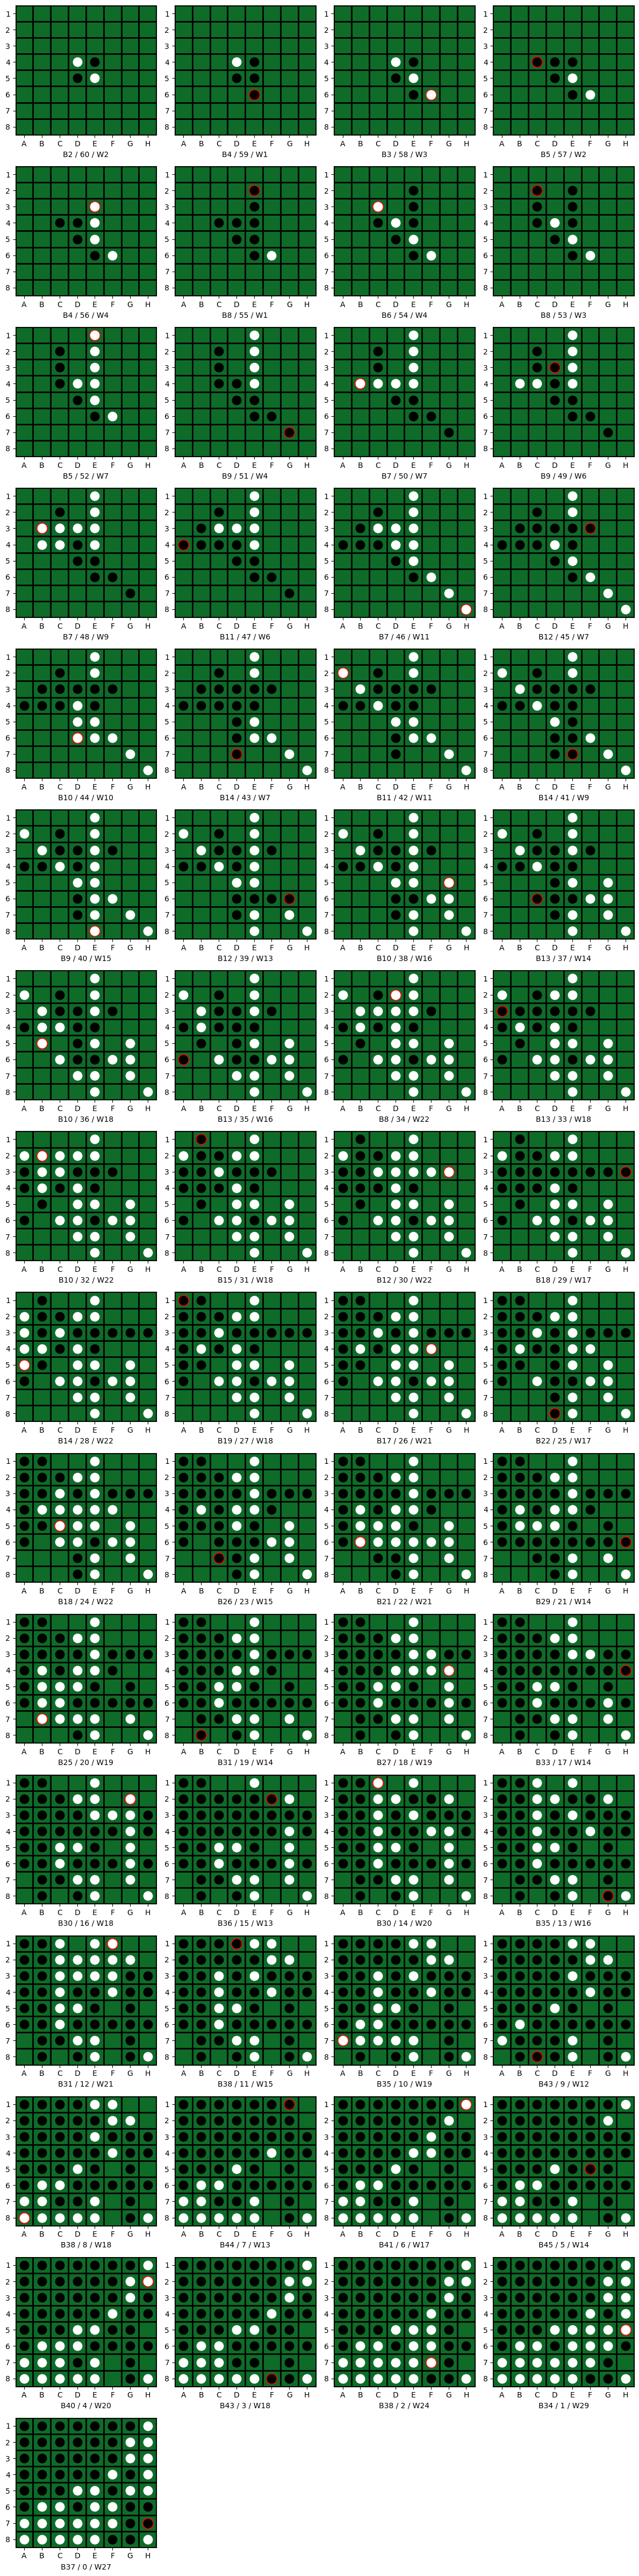

In [26]:
np.random.seed(1)
simulation_results = simulate_game(1, (GreedyPolicy(1), GreedyPolicy(1)))
_unique_bords, _unique_actions = drop_duplicate_boards(
    simulation_results[0].reshape(-1, 8, 8), simulation_results[1].reshape(-1, 2)
)
plot_othello_boards(_unique_bords, actions=_unique_actions)

In [27]:
%memit simulate_game(100, (GreedyPolicy(1), GreedyPolicy(1)))
%timeit simulate_game(100, (GreedyPolicy(1), GreedyPolicy(1)))

peak memory: 349.14 MiB, increment: 0.74 MiB
29.4 s ± 1.64 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Random vs. greedy policy

Last there was a simulation between random and greedy policy. Random playing as black and the greedy as white.

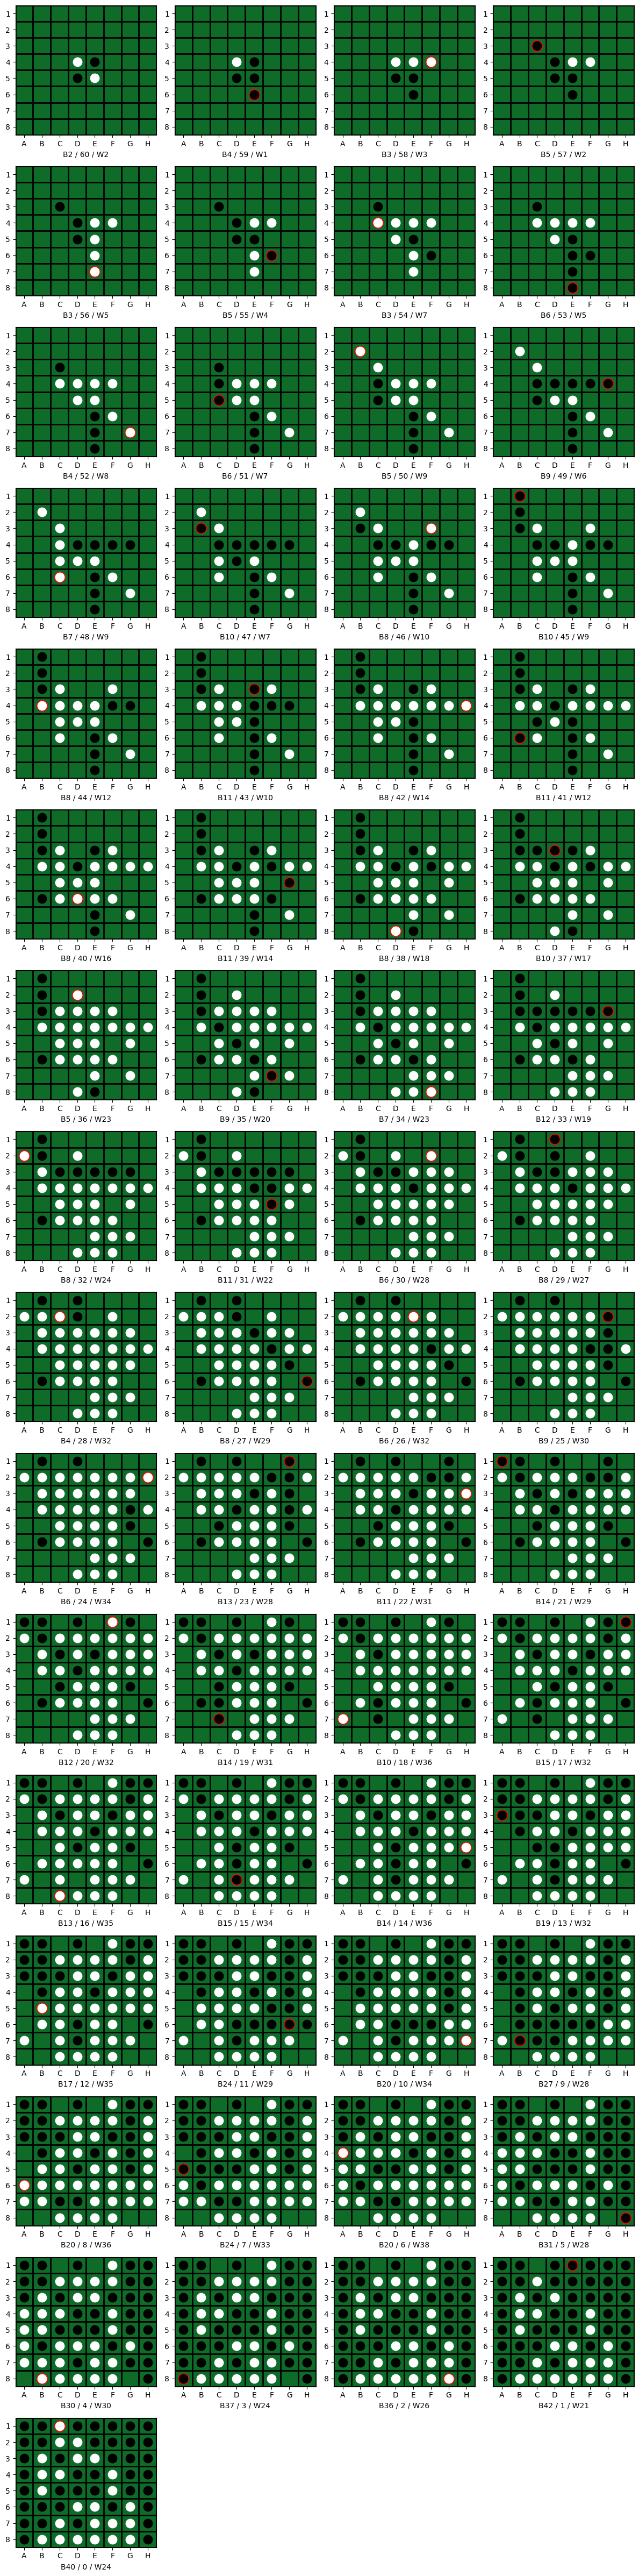

In [28]:
np.random.seed(2)
simulation_results = simulate_game(1, (RandomPolicy(1), GreedyPolicy(1)))
_unique_bords, _unique_actions = drop_duplicate_boards(
    simulation_results[0].reshape(-1, 8, 8), simulation_results[1].reshape(-1, 2)
)
plot_othello_boards(_unique_bords, actions=_unique_actions)

### Greedy vs. random policy

Last there was a simulation between the greedy policy as black and the random policy as white.

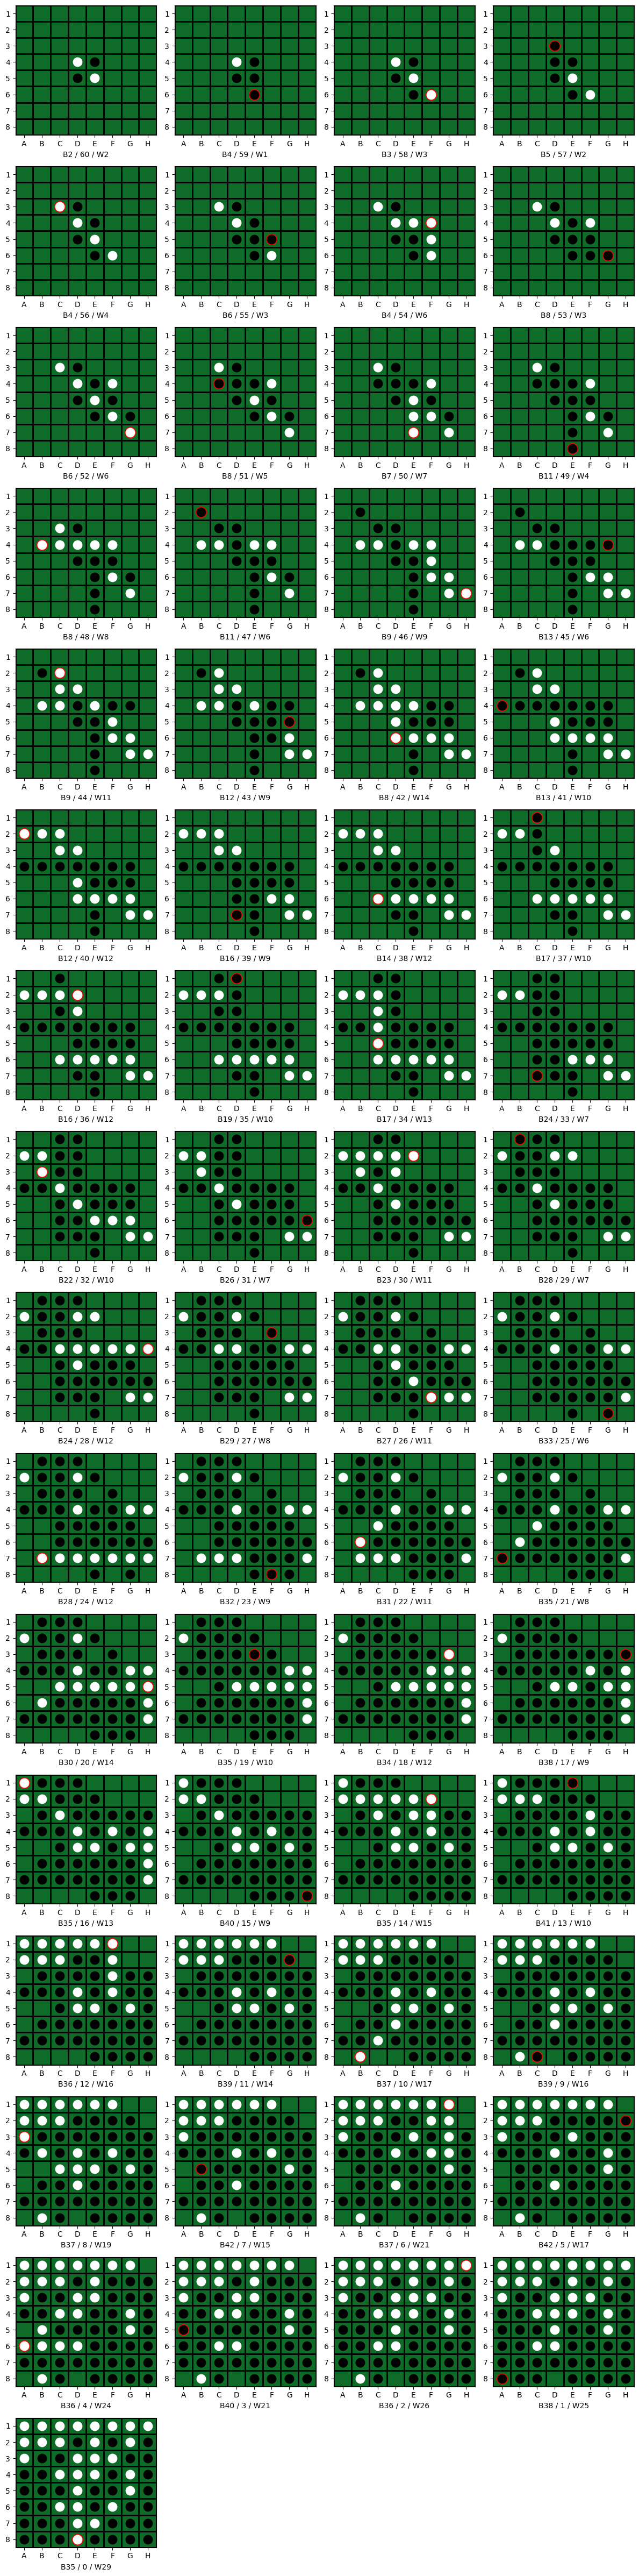

In [29]:
np.random.seed(3)
simulation_results = simulate_game(1, (GreedyPolicy(1), RandomPolicy(1)))
_unique_bords, _unique_actions = drop_duplicate_boards(
    simulation_results[0].reshape(-1, 8, 8), simulation_results[1].reshape(-1, 2)
)
plot_othello_boards(_unique_bords, actions=_unique_actions)

## Statistical examination of the natural action space and game result
As for many project some evaluation of the project is in order.

1. What is the expected distribution of scores
2. What is the expected distribution of possible actions

    a. over time
    
    b. ober space

The easiest and robustest way to analyse this is when analyzing randomly played games.

For this purpose we played a sample of 10,000 games and saved them for later analysis.

In [30]:
def load_board_history():
    if not os.path.exists("rnd_history.npy") and not os.path.exists("rnd_action.npy"):
        simulation_results = simulate_game(
            10_000, (RandomPolicy(1), RandomPolicy(1)), tqdm_on=True
        )
        board_history, action_history = simulation_results
        np.save("rnd_history.npy", board_history.astype(np.int8))
        np.save("rnd_action.npy", action_history.astype(np.int8))
    else:
        board_history = np.load("rnd_history.npy")
        action_history = np.load("rnd_action.npy")
    return board_history, action_history


_board_history, _action_history = load_board_history()
_board_history.shape, _action_history.shape

((70, 10000, 8, 8), (70, 10000, 2))

For those 10k games the possible actions where evaluated and saved for each and every turn in the game.

In [31]:
if not os.path.exists("turn_possible.npy"):
    __board_history = _board_history.copy()
    __board_history[1::2] = __board_history[1::2] * -1

    _poss_turns = get_possible_turns(
        __board_history.reshape((-1, 8, 8)), tqdm_on=True
    ).reshape((SIMULATE_TURNS, -1, 8, 8))
    np.save("turn_possible.npy", _poss_turns)
    del __board_history
_poss_turns = np.load("turn_possible.npy")
_poss_turns.shape, _action_history.shape

((70, 10000, 8, 8), (70, 10000, 2))

Those possible turms then where counted for all games in the history stack.

### Action space over time / tree search size estimation
The action space size can be drawn into a histogram by turn and a curve over the mean action space size.
This can be used to analyse in which area of the game that cant be solved absolutely.

In [32]:
count_poss_turns = np.sum(_poss_turns, axis=(2, 3))
mean_possibility_count = np.mean(count_poss_turns, axis=1)
std_possibility_count = np.std(count_poss_turns, axis=1)
cum_prod = count_poss_turns


@interact(turn=(0, 69))
def poss_turn_count(turn):
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))
    ax1, ax2, ax3, ax4 = axes.flatten()
    _mean_possibility_count = mean_possibility_count.copy()
    _std_possibility_count = std_possibility_count.copy()
    _mean_possibility_count[_mean_possibility_count <= 1] = 1
    _std_possibility_count[_std_possibility_count <= 1] = 1
    # np.cumprod(_mean_possibility_count[::-1], axis=0)[::-1]
    # todo what happens here=
    fig.suptitle(
        f"Action space size analysis\nThe total size is estimated to be around {np.prod(_mean_possibility_count):.2E}"
    )
    ax1.hist(count_poss_turns[turn], density=True)
    ax1.set_title(f"Histogram of the action space size for turn {turn}")
    ax1.set_xlabel("Action space size")
    ax1.set_ylabel("Action space size probability")
    ax2.set_title(f"Mean size of the action space per turn")
    ax2.set_xlabel("Turn")
    ax2.set_ylabel("Average possible moves")

    ax2.errorbar(
        range(70),
        mean_possibility_count,
        yerr=std_possibility_count,
        label="Mean action space size with error bars",
    )
    ax2.scatter(turn, mean_possibility_count[turn], marker="x")
    ax2.legend()

    action_space_cumprod = np.cumprod(_mean_possibility_count[::-1], axis=0)[::-1]
    ax4.plot(range(70), action_space_cumprod)

    ax4.scatter(turn, action_space_cumprod[turn], marker="x")
    ax4.set_yscale("log", base=10)
    ax4.set_xlabel("Turn")
    ax4.set_ylabel("Mean remaining total action space size")
    ax4.set_title(
        f"Remaining action space at {turn} = {action_space_cumprod[turn].round():.2E}"
    )
    fig.delaxes(ax3)
    fig.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=34, description='turn', max=69), Output()), _dom_classes=('widget-intera…

The analysis of the action space can be used to switch between a "normal" algorithm and an ANN-powered algorithm, depending on the network's performance and the speed requirements. If the average remaining decision tree is small enough, this can be done after step 52, but it could also start earlier, such as at step 50 or 48 if desired.

It is interesting to see that the action space for the first player (black) is much smaller than for the second player. 

In [33]:
black = mean_possibility_count[0::2]
white = mean_possibility_count[1::2]
df = pd.DataFrame(
    [
        {
            "white": np.prod(np.extract(white, white)),
            "black": np.prod(np.extract(black, black)),
        }
    ],
    index=["Total mean action-space"],
).T
del white, black
df

Total mean action-space
white             3.753117e+20
black             5.687159e+18

### Possibility that an action can be taken at a specifc turn

The following diagram displays the available positions for placing a stone at each turn. This can help compare the learning behavior of different policies, particularly with regard to the corners. A low probability for a corner suggests that the AI avoids giving corners to the opponent and tries to capture them for itself whenever possible.

In [34]:
mean_poss_turn = np.mean(_poss_turns, axis=1)


@interact(turn=(0, 69))
def turn_distribution_heatmap(turn):
    turn_possibility_on_field = mean_poss_turn[turn]

    sns.heatmap(
        turn_possibility_on_field,
        linewidth=0.5,
        square=True,
        annot=True,
        xticklabels="ABCDEFGH",
        yticklabels=list(range(1, 9)),
    )
    plt.title(f"Headmap of where stones can be placed on turn {turn}")

interactive(children=(IntSlider(value=34, description='turn', max=69), Output()), _dom_classes=('widget-intera…

### Statistic of skipped actions

Not all turns can be played. Plotted as a mean over the curse of the game it can be clearly seen that the first time a turn can be skipped is turn 9 and increases over time.

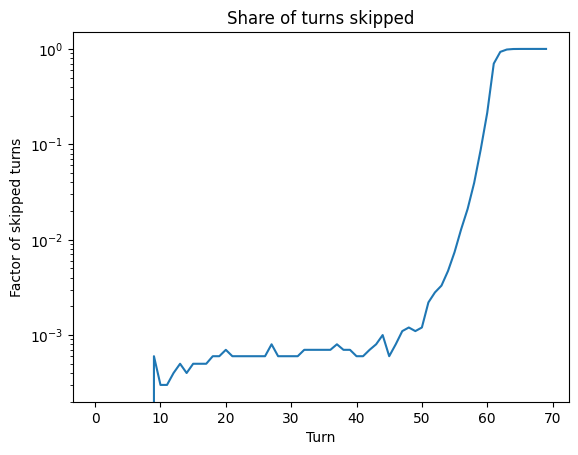

In [35]:
def history_changed(board_history: np.ndarray) -> np.ndarray:
    """Calculates if the board changed between actions.

    Args:
        board_history: A history of game boards. Shaped (70 * n * 8 * 8)
    """
    return ~np.all(
        np.roll(board_history, shift=1, axis=0) == board_history, axis=(2, 3)
    )


plt.title("Share of turns skipped")
plt.plot(1 - np.mean(history_changed(_board_history), axis=1))
plt.xlabel("Turn")
plt.ylabel("Factor of skipped turns")
plt.yscale("log", base=10)
plt.show()

## Hash branching
To calibrate the exploration rate properly we compared all the games in a stack of games. The graph shows the number of unique game boards at each of the game turns.
As can be seen below for random games the games start to be unique very fast.
For a proper directed exploration I assume the rate needs to be calibrated that the game still have some duplications of the best knwon game at the end of a game simulation left.

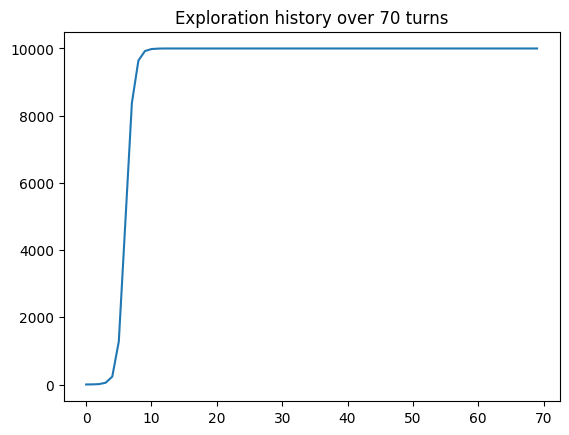

In [36]:
def calculate_board_branching(board_history) -> pd.Series:
    assert len(board_history.shape) == 4
    assert board_history.shape[-2:] == (8, 8)
    assert board_history.shape[0] == SIMULATE_TURNS
    return pd.Series(
        [count_unique_boards(board_history[turn]) for turn in range(SIMULATE_TURNS)]
    )


_ = calculate_board_branching(_board_history).plot(
    title=f"Exploration history over {_board_history.shape[0]} turns"
)

In [37]:
_direct_score = np.sum(_board_history, axis=(-2, -1))
_score = np.zeros_like(_direct_score)
_score[:-1] = _direct_score[1:] - _direct_score[:-1]
print(np.mean(_score, axis=1))

[ 3.0000e+00 -3.0000e+00  3.2566e+00 -3.4776e+00  3.4422e+00 -3.8032e+00
  3.7130e+00 -3.9864e+00  3.9188e+00 -4.1371e+00  4.0475e+00 -4.2540e+00
  4.1889e+00 -4.4112e+00  4.3339e+00 -4.4949e+00  4.5001e+00 -4.5824e+00
  4.5818e+00 -4.7497e+00  4.7366e+00 -4.8246e+00  4.8160e+00 -4.9348e+00
  4.9494e+00 -5.0466e+00  5.1068e+00 -5.1586e+00  5.2366e+00 -5.2766e+00
  5.3122e+00 -5.4081e+00  5.4527e+00 -5.5603e+00  5.5967e+00 -5.6423e+00
  5.7014e+00 -5.8357e+00  5.8643e+00 -5.9012e+00  5.9900e+00 -6.1215e+00
  6.1590e+00 -6.2150e+00  6.3472e+00 -6.4288e+00  6.5409e+00 -6.6730e+00
  6.7297e+00 -6.9038e+00  6.9386e+00 -7.0992e+00  7.2869e+00 -7.4165e+00
  7.5312e+00 -7.7480e+00  7.9052e+00 -7.9656e+00  7.8611e+00 -7.3040e+00
  3.0707e+00 -7.1540e-01  1.4300e-01 -1.9100e-02  3.4000e-03 -3.0000e-04
  5.0000e-04  0.0000e+00  0.0000e+00  0.0000e+00]


## Reword functions

For any kind of reinforcement learning is a reword function needed.
For otello this would be the final score, the information who won, changes to the score and the sum of the board.
A combination of those three also be possible.
It is probably not be possible to weight the current score to high in a reword function since that would be to close to a classic greedy algorithm.
But some direct influence would increase the learning speed.
In the next section are all three reword functions implemented to be combined and weight later on as needed.

### Evaluate the final game score

In Otello, the empty fields at the end of the game are counted for the player with more stones. The function below calculates this and returns the score difference for player 1 (black).

In [38]:
def final_boards_evaluation(boards: np.ndarray) -> np.ndarray:
    """Evaluates the board at the end of the game.

    All unused fields are added to the score of the player that has more stones with his color up.
    This score only applies to the end of the game.
    Normally the score is represented by the number of stones each player has.
    In this case the score was combined by building the difference.

    Args:
        boards: A stack of game bords ot the end of the game. Shaped (n * 8 * 8)

    Returns:
        the combined score for both player.
    """
    score1, score2 = np.sum(boards == 1, axis=(1, 2)), np.sum(boards == -1, axis=(1, 2))
    player_1_won = score1 > score2
    player_2_won = score1 < score2
    score1_final = 64 - score2[player_1_won] * 2
    score2_final = 64 - score1[player_2_won] * 2
    score = np.zeros(boards.shape[0])
    score[player_1_won] = score1_final
    score[player_2_won] = -score2_final
    return score


np.random.seed(2)
_boards = simulate_game(10, (RandomPolicy(1), RandomPolicy(1)))[0]
np.testing.assert_array_equal(
    np.sum(_boards[-1], axis=(1, 2)), final_boards_evaluation(_boards[-1])
)
np.random.seed(2)
np.testing.assert_array_equal(
    np.array([-6.0, -36.0, -12.0, -16.0, 38.0, -12.0, 2.0, -22.0, 2.0, 10.0]),
    final_boards_evaluation(
        simulate_game(10, (RandomPolicy(1), RandomPolicy(1)))[0][-1]
    ),
)

np.random.seed(2)
boards = simulate_game(10, (RandomPolicy(1), RandomPolicy(1)))[0][-1]
boards[:, 4, :] = 0
np.testing.assert_array_equal(
    np.array([-14.0, -38.0, -14.0, -22.0, 40.0, -16.0, -14.0, -28.0, 0.0, 20.0]),
    final_boards_evaluation(boards),
)

_boards = get_new_games(EXAMPLE_STACK_SIZE)
%timeit final_boards_evaluation(_boards)

411 µs ± 88.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [39]:
def calculate_final_evaluation_for_history(board_history: np.ndarray) -> np.ndarray:
    """Calculates the final scores for a stack of game histories.

    Args:
        board_history: A stack of game histories.
    """
    final_evaluation = final_boards_evaluation(board_history[-1])
    return final_evaluation / 64


np.random.seed(2)
_boards = simulate_game(10, (RandomPolicy(1), RandomPolicy(1)))[0]
np.testing.assert_array_equal(
    np.array([-6.0, -36.0, -12.0, -16.0, 38.0, -12.0, 2.0, -22.0, 2.0, 10.0]) / 64,
    calculate_final_evaluation_for_history(_boards),
)

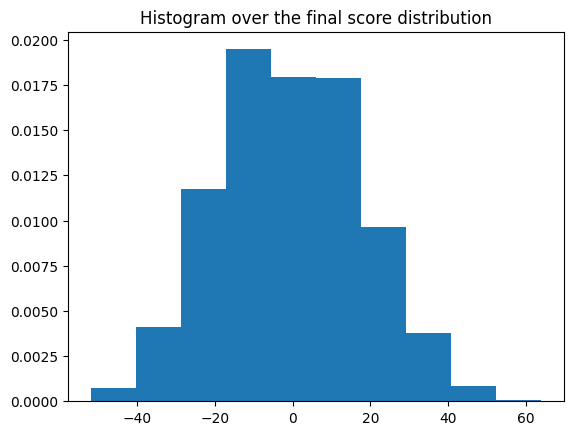

In [40]:
assert len(calculate_final_evaluation_for_history(_board_history).shape) == 1
_final_eval = calculate_final_evaluation_for_history(_board_history)
plt.title("Histogram over the final score distribution")
plt.hist((_final_eval * 64), density=True)
plt.show()

### Evaluation game by stones only

The next evaluation is just by counting stones by color and building the difference between both. In this implementation it can also be called the sum of a board.

In [41]:
def evaluate_boards(boards: np.ndarray) -> np.ndarray:
    """Counts the stones each player has on the board.

    Args:
        boards: A stack of boards for evaluation. Shaped (n * 8 * 8)

    Returns:
        the combined score for both players.
    """
    assert boards.shape[-2:] == (8, 8)
    return np.sum(boards, axis=(-1, -2))


np.random.seed(1)
np.testing.assert_array_equal(
    evaluate_boards(simulate_game(10, (RandomPolicy(1), RandomPolicy(1)))[0][-1]),
    np.array([-30, -14, -8, 4, -4, -8, -36, 14, -16, -4]),
)
np.random.seed(2)
np.testing.assert_array_equal(
    evaluate_boards(simulate_game(10, (RandomPolicy(1), RandomPolicy(1)))[0][-1]),
    np.array([-6, -36, -12, -16, 38, -12, 2, -22, 2, 10]),
)
np.testing.assert_array_equal(
    evaluate_boards(simulate_game(10, (RandomPolicy(1), RandomPolicy(1)))[0]).shape,
    (70, 10),
)
np.random.seed(3)
np.testing.assert_array_equal(
    evaluate_boards(simulate_game(10, (RandomPolicy(1), RandomPolicy(1)))[0][:4, :3]),
    np.array([[0, 0, 0], [3, 3, 3], [0, 0, 0], [5, 3, 3]]),
)

_boards = get_new_games(EXAMPLE_STACK_SIZE)
%timeit evaluate_boards(_boards)

59.5 µs ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


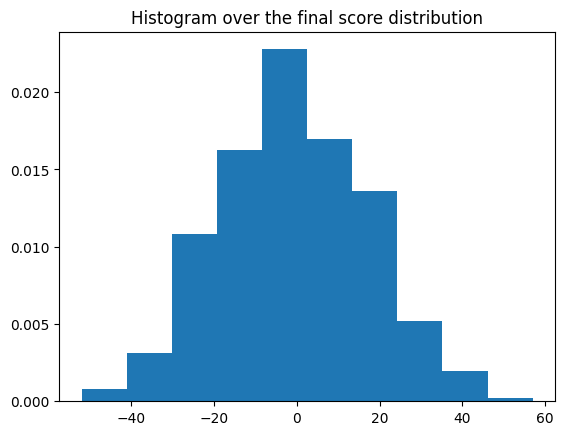

In [42]:
_eval = evaluate_boards(_board_history[-1])
plt.title("Histogram over the final score distribution")
plt.hist(_eval, density=True)
plt.show()

### Evaluate the winner of a game

The last function evaluates who won by calculating who signum function of the sum of the numpy array representing the board.
The resulting number would be one of the game was won by the player (white) or -1 if the enemy (black) won. The result would also

In [43]:
def calculate_who_won(board_history: np.ndarray) -> np.ndarray:
    """Checks who won or is winning a game.

    Args:
        board_history: A stack of boards for evaluation. Shaped (70 * n * 8 * 8)

    Returns:
        The information who won for both player. 1 meaning the player won, -1 means the opponent lost. 0 represents a patt.
    """
    assert board_history.shape[-2:] == (8, 8)
    assert board_history.shape[0] == 70
    return np.sign(np.sum(board_history[-1], axis=(1, 2)))


np.random.seed(1)
np.testing.assert_array_equal(
    calculate_who_won(simulate_game(10, (RandomPolicy(1), RandomPolicy(1)))[0]),
    np.array([-1, -1, -1, 1, -1, -1, -1, 1, -1, -1]),
)
np.random.seed(2)
np.testing.assert_array_equal(
    calculate_who_won(simulate_game(10, (RandomPolicy(1), RandomPolicy(1)))[0]),
    np.array([-1, -1, -1, -1, 1, -1, 1, -1, 1, 1]),
)


_boards = simulate_game(EXAMPLE_STACK_SIZE, (RandomPolicy(1), RandomPolicy(1)))[0]
%timeit calculate_who_won(_boards)

126 µs ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


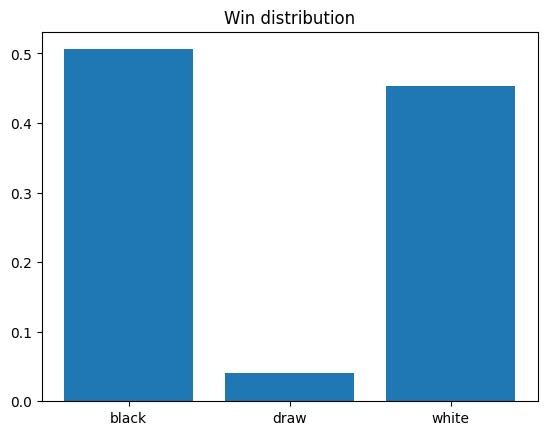

In [44]:
plt.title("Win distribution")
plt.bar(
    ["black", "draw", "white"],
    pd.Series(calculate_who_won(_board_history)).value_counts().sort_index()
    / _board_history.shape[1],
)
plt.show()

### Direct turn evaluation

Besides evaluating the turn there is always the possibility to calculate how much of an direct impact a single turn had.

In [45]:
def calculate_direct_score(board_history: np.ndarray) -> np.ndarray:
    """Calculates the delta score for all actions.

    Args:
        board_history: A history of board games or a stack of board games.  Shaped (70 * n * 8 * 8)
    """
    assert board_history.shape[0] == 70
    assert board_history.shape[-2:] == (8, 8)
    direct_score = np.sum(board_history, axis=(-2, -1))
    score = np.zeros_like(direct_score)
    score[:-1] = direct_score[1:] - direct_score[:-1]
    return score / 64


assert len(calculate_direct_score(_board_history).shape) == 2
assert calculate_direct_score(_board_history).shape[0] == SIMULATE_TURNS
np.random.seed(2)
np.testing.assert_equal(
    calculate_direct_score(simulate_game(10, (RandomPolicy(1), RandomPolicy(1)))[0])[
        :, 0
    ][:10]
    * 64,
    np.array(
        [3.0, -3.0, 3.0, -5.0, 5.0, -5.0, 3.0, -3.0, 7.0, -5.0],
    ),
)

When plotting the direct score it can be easily seen that the later turnse are point-wise more important. A bad opening however will not allow the player to keep those points. But it is easy to see that points not made at the beginning of the game can be made at the end of the game. This allows for concentration on the gameplay and some preparation at the start of the game.

In [46]:
score_history = calculate_direct_score(_board_history)
score_history *= 64


@interact(turn=(0, 59))
def hist_direct_score(turn):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(
        f"Action space size analysis / total size estimate {np.prod(np.extract(mean_possibility_count, mean_possibility_count)):.4g}"
    )

    ax1.set_title(
        f"Histogram of scores changes on turn {turn} by {'white' if turn % 2 == 0 else 'black'}"
    )
    score = score_history[turn]
    bins = max(1, int(max(score) - min(score)))
    ax1.hist(score, density=True, bins=bins)
    ax1.set_xlabel("Points made")
    ax1.set_ylabel("Score probability")
    ax2.set_title("Points scored at turn")
    ax2.set_xlabel("Turn")
    ax2.set_ylabel("Average points scored")
    ax2.errorbar(
        range(60),
        np.abs(np.mean(score_history, axis=1)[:60]),
        yerr=np.std(score_history, axis=1)[:60],
        label="Mean score at turn",
    )
    ax2.scatter(
        turn, np.abs(np.mean(score_history, axis=1))[:60][turn], marker="x", color="red"
    )
    ax2.legend()
    plt.show()

interactive(children=(IntSlider(value=29, description='turn', max=59), Output()), _dom_classes=('widget-intera…

## Creating Q-Learning Policies
Q-learning is a classic reinforcement learning technique. The Q-function is an action-value function that returns the expected value of an action in a given state.

$Q^\pi(s_t,a_t)=\sum^{60}_{t=turn}\gamma^{60-t} \cdot R_t$

With this function, all actions in a given state can be evaluated, and the most beneficial action can be taken. With classical reinforcement learning, a table for situations and actions is explored and slowly filled. With ANNs, there is the possibility to use an AI model that can interpolate between situations and should not need to explore the complete game tree to solve some situations.

### Calculating discount tables

Since the game stack contains all steps, even if no action is possible, this needs to be corrected. The normal formula for a reward is:

$E(s_{turn},a_{turn}) = \sum^{60}_{t=turn}\gamma^{60-t} \cdot R_t$

Since turns that can't be taken do not have the element of uncertainty, the discounting has to be excluded by setting the value to $1$ instead of $\gamma$.

$\gamma^*_t =\begin{cases}1 & |a_t|=0\\gamma & |a_t|>0\end{cases}$

$E(s_{turn},a_{turn}) = \prod_{t=turn}^{70}\gamma^*_t \cdot R_t$

The table below contains the aggregated discount factors ($\prod_{t=turn}^{70}\gamma^*_t$) for each reward fitting to the state history. This setup also allows to reward the certainty gained by taking the choice of the action from the opponent. It can be argued that also all turns where a player had no choice how to act should not be discounted. But this will increase calculation requirements to nearly double, which is currently not acceptable since computation time and code complexity are bottlenecks.
Since at least 10 turns in the stack ar not taken boat policies should lead to ruffly equal results.

In [47]:
def get_gamma_table(board_history: np.ndarray, gamma_value: float) -> np.ndarray:
    """Calculates a discount table for a board history.

    Args:
        board_history: A history of game boards. Shaped (70 * n * 8 * 8)
        gamma_value: The default discount factor.
    """
    unchanged = history_changed(board_history)
    gamma_values = np.ones_like(unchanged, dtype=float)
    gamma_values[unchanged] = gamma_value
    return gamma_values


assert get_gamma_table(_board_history, 0.8).shape == _board_history.shape[:2]

### Calculating rewords

To calculate the rewards for the Reversi AI, we will use the $\gamma$ values to combine the rewards obtained during the game with the functions calculate_direct_score, calculate_final_evaluation_for_history, and calculate_who_won.

The rewards obtained will be used to build a weighted sum of rewards, where most of the rewards are terminal rewards awarded at the end of the game and discounted back over the course of the game. The sum of the reward weights is always 1, with the third value calculated from the first two.

The direct score is the only part of the reward that is awarded before the terminal reward. This setup allows for experimentation with different types of rewards to train the model, with different definitions of what is considered "best" depending on factors such as initial startup time, stability, and quality of results.

Although $Q^\pi$ depends on state and action, the rewards are returned and do not require a specified action to be given, since the action is implied by the structure of the data.

In [48]:
def calculate_q_reword(
    board_history: np.ndarray,
    who_won_fraction: float = 0.2,
    final_score_fraction: float = 0.2,
    gamma: float = 0.8,
) -> np.ndarray:
    """Calculates a Q reword for a stack of states.

    Args:
        board_history: A stack ob board histories to calculate q_rewords for.
        who_won_fraction: This factor describes how the winner of the game should be weighted. Expected value is in [0, 1].
        final_score_fraction: This factor describes how important the final score of the game should be weighted. Expected value is in [0, 1].
        gamma: The discount value fo all turns that had a choice.
    """
    assert who_won_fraction + final_score_fraction <= 1
    assert final_score_fraction >= 0
    assert who_won_fraction >= 0

    gama_table = get_gamma_table(board_history, gamma)
    combined_score = np.zeros_like(gama_table)
    combined_score += calculate_direct_score(board_history) * (
        1 - (who_won_fraction + final_score_fraction)
    )
    combined_score[-1] += (
        calculate_final_evaluation_for_history(board_history)
        * final_score_fraction
        / 0.7
    )
    combined_score[-1] += calculate_who_won(board_history) * who_won_fraction
    for turn in range(SIMULATE_TURNS - 1, 0, -1):
        values = gama_table[turn] * combined_score[turn]
        combined_score[turn - 1] += values

    return combined_score

The calculated q_learning rewords look than as shown below. For the different distributions of rewords by factor.

In [49]:
calculate_q_reword(
    _board_history, gamma=0.7, who_won_fraction=0, final_score_fraction=1
)

array([[-9.07181894e-11, -3.85552305e-10,  6.80386421e-11, ...,
         9.07181894e-11,  0.00000000e+00,  1.13397737e-10],
       [-1.29597413e-10, -5.50789007e-10,  9.71980601e-11, ...,
         1.29597413e-10,  0.00000000e+00,  1.61996767e-10],
       [-1.85139162e-10, -7.86841439e-10,  1.38854372e-10, ...,
         1.85139162e-10,  0.00000000e+00,  2.31423953e-10],
       ...,
       [-1.78571429e-01, -7.58928571e-01,  1.33928571e-01, ...,
         1.78571429e-01,  0.00000000e+00,  2.23214286e-01],
       [-1.78571429e-01, -7.58928571e-01,  1.33928571e-01, ...,
         1.78571429e-01,  0.00000000e+00,  2.23214286e-01],
       [-1.78571429e-01, -7.58928571e-01,  1.33928571e-01, ...,
         1.78571429e-01,  0.00000000e+00,  2.23214286e-01]])

In [50]:
calculate_q_reword(
    _board_history, gamma=0.8, who_won_fraction=1, final_score_fraction=0
)[:, 0]

array([-1.53249554e-06, -1.91561943e-06, -2.39452428e-06, -2.99315535e-06,
       -3.74144419e-06, -4.67680524e-06, -5.84600655e-06, -7.30750819e-06,
       -9.13438523e-06, -1.14179815e-05, -1.42724769e-05, -1.78405962e-05,
       -2.23007452e-05, -2.78759315e-05, -3.48449144e-05, -4.35561430e-05,
       -5.44451787e-05, -6.80564734e-05, -8.50705917e-05, -1.06338240e-04,
       -1.32922800e-04, -1.66153499e-04, -2.07691874e-04, -2.59614843e-04,
       -3.24518554e-04, -4.05648192e-04, -5.07060240e-04, -6.33825300e-04,
       -7.92281625e-04, -9.90352031e-04, -1.23794004e-03, -1.54742505e-03,
       -1.93428131e-03, -2.41785164e-03, -3.02231455e-03, -3.77789319e-03,
       -4.72236648e-03, -5.90295810e-03, -7.37869763e-03, -9.22337204e-03,
       -1.15292150e-02, -1.44115188e-02, -1.80143985e-02, -2.25179981e-02,
       -2.81474977e-02, -3.51843721e-02, -4.39804651e-02, -5.49755814e-02,
       -6.87194767e-02, -8.58993459e-02, -1.07374182e-01, -1.34217728e-01,
       -1.67772160e-01, -

In [51]:
calculate_q_reword(
    _board_history, gamma=0.8, who_won_fraction=0, final_score_fraction=0
)[:, 0] * 64

array([  1.53941436,  -1.82573204,   1.46783494,  -1.91520632,
         1.3559921 ,  -4.55500988,   0.55623766,  -3.05470293,
        -0.06837866,  -6.33547333,   0.83065834,  -2.71167707,
         0.36040366,  -3.29949543,   2.12563071,  -3.59296161,
         6.75879799,   4.69849749,   9.62312186,   5.77890232,
        13.47362791,   8.09203488,  13.8650436 ,   1.0813045 ,
         5.10163063,   0.12703829,   3.90879786,   1.13599733,
         5.16999666,  -4.78750418,   0.26561978,  -3.41797528,
         1.9775309 ,  -3.77808638,  -0.97260797,  -7.46575996,
         1.91780005,  -1.35274994,   4.55906257,  -8.05117178,
         1.18603527,  -4.76745591,   0.29068011,  -3.38664986,
        -0.48331232,  -4.3541404 ,   3.3073245 ,   0.38415562,
         4.23019452,   1.53774316,   8.17217894,   1.46522368,
         5.5815296 ,  -4.273088  ,  -1.59136   , -15.7392    ,
        -8.424     , -24.28      , -26.6       , -26.6       ,
       -17.        , -17.        ,   0.        ,   0.  

### Layer Initialization Function

When training the ANN, it is important to initialize the weights and biases of its layers before starting the training process. This can be done using various techniques such as random initialization or using pre-trained weights. The choice of initialization function can have an impact on the training speed and the quality of the learned model. Therefore, we will carefully select an appropriate initialization function to ensure the best possible training outcome for our Otello AI.

In [52]:
def weights_init_normal(m):
    """Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.
    Source: https://stackoverflow.com/a/55546528/11003343
    """

    classname = m.__class__.__name__
    # for every Linear layer in a model
    if classname.find("Linear") != -1:
        y = m.in_features
        # m.weight.data should be taken from a normal distribution
        m.weight.data.normal_(0.0, 1 / np.sqrt(y))
        # m.bias.data should be 0
        m.bias.data.fill_(0)

### ANN Architecture

The architecture of an Artificial Neural Network (ANN) is defined by its inputs and outputs. In the case of Q-Learning ANNs for the board game Otello, the network should calculate the expected reward for the current state and a proposed action.

The state of the game board is represented by a 8x8 array, where each cell can be either empty, occupied by a black stone, or occupied by a white stone. The proposed action is represented by an array of equal size, using one-hot encoding to indicate the cell where a stone is proposed to be placed.

The output of the ANN should be a value between -1 and 1, which suggests using a $\tanh$ activation function. Since the game board is small and the position of the stones is crucial, it was decided to use only conventional layers, without any Long Short-Term Memory (LSTM) layer or other architectures for sequences and time series, as the history of the game does not matter.

Therefore, the input size of the network is (8 x 8 x 2) and the output size is 1, representing the expected reward for the proposed action in the current state of the game board.

In [53]:
class DQLNet(nn.Module):
    """A simple ANN structure"""

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8 * 8 * 2, 128 * 2)
        self.fc2 = nn.Linear(128 * 2, 128 * 3)
        self.fc3 = nn.Linear(128 * 3, 128 * 2)
        self.fc4 = nn.Linear(128 * 2, 1)

    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = functional.relu(x)
        x = self.fc2(x)
        x = functional.relu(x)
        x = self.fc3(x)
        x = functional.relu(x)
        x = self.fc4(x)
        x = torch.tanh(x)
        return x

Since the first ANN was initially not very successful a reduced version was also tried.

In [54]:
class DQLSimple(nn.Module):
    """A even simpler ANN structure"""

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8 * 8 * 2, 64 * 3)
        self.fc2 = nn.Linear(64 * 3, 128 * 2)
        self.fc3 = nn.Linear(128 * 2, 1)

    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = functional.relu(x)
        x = self.fc2(x)
        x = functional.relu(x)
        x = self.fc3(x)
        x = torch.tanh(x)
        return x


assert DQLNet().forward(np.zeros((5, 2, 8, 8))).shape == (5, 1)

In [55]:
class SymmetryMode(Enum):
    MULTIPLY = "MULTIPLY"
    BREAK_SEQUENCE = "BREAK_SEQUENCE"

In [56]:
_board_history, _action_history = simulate_game(100, (RandomPolicy(1), RandomPolicy(1)))
_board_history.shape, _action_history.shape

((70, 100, 8, 8), (70, 100, 2))

When using the Q-Learning networks as defined above in the sections `DQLNet` and `DQLSimple` the state and the actions need to be converted into the input format accepted by the Q-Learning network.
The function below merges both input values and gets them into the proper format.

In [326]:
def action_to_q_learning_format(
    board_history: np.ndarray, action_history: np.ndarray
) -> np.ndarray:
    """Formats the board history and the action history into Q-Learning inputs.

    Args:
        board_history: A stack of board histories.
        action_history: A stack of action histories.
    """
    q_learning_format = np.zeros(
        (SIMULATE_TURNS, board_history.shape[1], 2, 8, 8), dtype=float
    )
    q_learning_format[:, :, 0, :, :] = board_history
    q_learning_format[:, :, 1, :, :] = -1

    game_index = list(range(board_history.shape[1]))
    for turn_index in range(SIMULATE_TURNS):
        q_learning_format[
            turn_index,
            game_index,
            1,
            action_history[turn_index, game_index, 0],
            action_history[turn_index, game_index, 1],
        ] = 1
    return q_learning_format


%timeit action_to_q_learning_format(_board_history, _action_history)
%memit action_to_q_learning_format(_board_history, _action_history)

37.2 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
peak memory: 1014.62 MiB, increment: 0.23 MiB


### Exploiting the game symetry for data generation
The game's axis ambivalence allows for the generation of up to $2^3$ unique boards by using symmetries. The symmetry axes are vertical and horizontal flips, as well as the transposed versions. This results in $2^3$ symmetry variations that can be used to train the artificial neural network (ANN). Instead of using all $2^3$ variations, a random selection is taken to break the strict sequence and facilitate training. This functions also converts into the proper format for Q-Learning.

In [58]:
def build_symetry_action(
    board_history: np.ndarray, action_history: np.ndarray
) -> np.ndarray:
    """Build a set of symmetrical game histories in the style of a q_learning learning policy.

    Args:
        board_history: A history of game states.
        action_history: A history fo action states.
    """
    board_history = board_history.copy()
    board_history[1::2] *= -1
    q_learning_format = np.zeros(
        (2, 2, 2, SIMULATE_TURNS, board_history.shape[1], 2, 8, 8)
    )
    q_learning_format[0, 0, 0, :, :, :, :, :] = action_to_q_learning_format(
        board_history, action_history
    )
    q_learning_format[1, 0, 0, :, :, :, :, :] = np.transpose(
        q_learning_format[0, 0, 0, :, :, :, :, :], [0, 1, 2, 4, 3]
    )
    q_learning_format[:, 1, 0, :, :, :, :, :] = q_learning_format[
        :, 0, 0, :, :, :, ::-1, :
    ]
    q_learning_format[:, :, 1, :, :, :, :, :] = q_learning_format[
        :, :, 0, :, :, :, :, ::-1
    ]
    return q_learning_format


%timeit build_symetry_action(_board_history, _action_history)
%memit build_symetry_action(_board_history, _action_history)
build_symetry_action(_board_history, _action_history).shape

61.5 ms ± 4.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
peak memory: 441.80 MiB, increment: 0.36 MiB


(2, 2, 2, 70, 100, 2, 8, 8)

During the training of an ANN, it is necessary to monitor its progress by tracking its loss. Additional metrics are also used to measure significant results separately, since we work with a composite reward in reinforcement learning. Therefore, the final score and win ratio are tracked and can be plotted using the function below.

In [59]:
def live_history(training_history: pd.DataFrame, ai_name: str | None = None):
    """Plots the training history of a Q-Learning Policy.

    Args:
        training_history: The training history of a Q-Learning Policy.
        ai_name: The optional name of the policy.
    """
    training_history.columns = training_history.columns.to_series().apply(
        lambda x: "{0} {1}".format(*x)
    )
    clear_output(wait=True)
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(14, 7))
    _ = (
        training_history[
            [c for c in training_history.columns if c.endswith("final_score")]
        ]
        .rename(lambda c: c.split(" ")[0], axis=1)
        .plot(ax=ax1)
    )
    ax1.set_title("Final score")
    ax1.set_xlabel("epochs")
    ax1.set_ylabel("Average final score")
    _ = (
        training_history[[c for c in training_history.columns if c.endswith("win")]]
        .rename(lambda c: c.split(" ")[0], axis=1)
        .plot(ax=ax2)
    )
    ax2.set_title("Win score")
    ax2.set_xlabel("epochs")
    ax2.set_ylabel("Average signum winner")
    _ = (
        np.sqrt(
            training_history[
                [c for c in training_history.columns if c.startswith("loss")]
            ]
        )
        .rename(lambda c: c.split(" ")[1], axis=1)
        .plot(ax=ax3)
    )
    ax3.set_yscale("log")
    ax3.set_xlabel("epochs")
    ax3.set_ylabel("MSE")
    ax3.set_title("Loss")
    fig.suptitle(f"Training history of {ai_name}" if ai_name else f"Training history")
    fig.tight_layout()

### The QLPolicy Class

With the elements created above, we can now assemble a cohesive class that encompasses all the functionality needed to train a simple Q-Learning model. The class includes functions for training as a whole, per epoch, and per batch, as well as tools for analysis, internal policies, and logging the training history and quality monitoring.

In [60]:
class QLPolicy(GamePolicy):
    """
    A simple Q-Learning policy.
    """

    # noinspection PyProtectedMember
    def __init__(
        self,
        epsilon: float,
        neural_network: DQLNet | DQLSimple,
        symmetry_mode: SymmetryMode,
        gamma: float = 0.8,
        who_won_fraction: float = 0,
        final_score_fraction: float = 0,
        optimizer: torch.optim.Optimizer | None = None,
        loss: nn.modules.loss._Loss | None = None,
    ):
        """Creates a Q-learning policy using the specified arguments.

        Args:
            epsilon: Defines how greedy the policy should act. A value of 1 means the policy is completely greedy.
            neural_network: The neural network structure used for this policy.
            symmetry_mode: The symmetry mode used to select data. Choose from 'all_symmetric_variances' or 'random_choice'.
            gamma: The discount factor used in the Q-learning algorithm.
            who_won_fraction: The weight of the reward based on who won the game.
            final_score_fraction: The weight of the reward based on the final score of the game.
            optimizer: The optimizer used to train the model.
            loss: The loss function used to train the model. None defaults to MSE.
        """
        super().__init__(epsilon)
        assert 0 <= gamma <= 1
        self.gamma: float = gamma
        del gamma
        self.symmetry_mode: SymmetryMode = symmetry_mode
        del symmetry_mode
        self.neural_network: DQLNet | DQLSimple = neural_network
        del neural_network
        self.who_won_fraction: float = who_won_fraction
        del who_won_fraction
        self.final_score_fraction: float = final_score_fraction
        del final_score_fraction

        if optimizer is None:
            self.optimizer = torch.optim.Adam(self.neural_network.parameters(), lr=5e-5)
        else:
            self.optimizer = optimizer
        if loss is None:
            self.loss = nn.MSELoss()
        else:
            self.loss = loss
        self.training_results: list[dict[tuple[str, str], float]] = []
        self.loss_history: list[float] = []

    @property
    def policy_name(self) -> str:
        """Generates a name for a Q-Learning policy from all their arguments"""
        symmetry_name = {SymmetryMode.MULTIPLY: "M", SymmetryMode.BREAK_SEQUENCE: "B"}
        g = f"{self.gamma:.1f}".replace(".", "")
        ww = f"{self.who_won_fraction:.1f}".replace(".", "")
        fsf = f"{self.final_score_fraction:.1f}".replace(".", "")
        return f"QL-{symmetry_name[self.symmetry_mode]}-G{g}-WW{ww}-FSF{fsf}-{self.neural_network.__class__.__name__}-{self.loss.__class__.__name__}"

    def __repr__(self) -> str:
        return self.policy_name

    def __str__(self) -> str:
        return self.policy_name

    def _internal_policy(self, boards: np.ndarray) -> np.ndarray:
        """Calculates the q-learning values for all the possible actions.

        Args:
            boards: A stack of game boards.
        """
        results = np.zeros_like(boards, dtype=float)
        results = torch.from_numpy(results).float()
        q_learning_boards = np.zeros((boards.shape[0], 2, 8, 8))
        q_learning_boards[:, 0, :, :] = boards
        poss_turns = boards == 0  # checks where fields are empty.
        poss_turns &= binary_dilation(boards == -1, SURROUNDING)
        turn_possible = np.any(poss_turns, axis=0)
        for action_x, action_y in itertools.product(range(8), range(8)):
            if not turn_possible[action_x, action_y]:
                continue
            _q_learning_board = q_learning_boards[
                poss_turns[range(boards.shape[0]), action_x, action_y]
            ].copy()
            _q_learning_board[
                range(_q_learning_board.shape[0]), 1, action_x, action_y
            ] = 1

            ql_result = self.neural_network.forward(_q_learning_board)
            results[poss_turns[:, action_x, action_y], action_x, action_y] = (
                ql_result.reshape(-1) + 0.1
            )
        return results.cpu().detach().numpy()

    def generate_trainings_data(
        self, generate_data_size: int
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """Generates trainings data.

        Args:
            generate_data_size: The number of games that should be used to generate trainingsdata.
        """
        train_boards, train_actions = simulate_game(generate_data_size, (self, self))
        action_possible = ~np.all(train_actions[:, :] == -1, axis=2)
        q_leaning_formatted_action = build_symetry_action(train_boards, train_actions)
        q_rewords = calculate_q_reword(
            board_history=train_boards,
            who_won_fraction=self.who_won_fraction,
            final_score_fraction=self.final_score_fraction,
        )
        q_rewords[1::2, :] *= -1
        if self.symmetry_mode == SymmetryMode.MULTIPLY:
            new_q_rewords = np.zeros((2, 2, 2) + q_rewords.shape)
            for i, k, j in itertools.product((0, 1), (0, 1), (0, 1)):
                new_q_rewords[i, k, j] = q_rewords
            q_rewords = new_q_rewords
            action_possible = np.array([action_possible] * 8).reshape(-1)

        elif self.symmetry_mode == SymmetryMode.BREAK_SEQUENCE:
            axis1 = np.random.randint(0, high=2, size=SIMULATE_TURNS, dtype=int)
            axis2 = np.random.randint(0, high=2, size=SIMULATE_TURNS, dtype=int)
            axis3 = np.random.randint(0, high=2, size=SIMULATE_TURNS, dtype=int)
            q_leaning_formatted_action = q_leaning_formatted_action[
                axis1, axis2, axis3, range(SIMULATE_TURNS)
            ]
            action_possible = action_possible.reshape(-1)

        return (
            torch.from_numpy(
                q_leaning_formatted_action.reshape(-1, 2, BOARD_SIZE, BOARD_SIZE)[
                    action_possible
                ]
            ).float(),
            torch.from_numpy(q_rewords.reshape(-1, 1)[action_possible]).float(),
        )

    def train_batch(self, nr_of_games: int) -> None:
        """Trains a single batch of on a set of games.

        Args:
            nr_of_games: The number of games that should be played to train the model.
        """
        x_train, y_train = self.generate_trainings_data(nr_of_games)
        y_pred = self.neural_network.forward(x_train)
        loss_score = self.loss(y_pred, y_train)
        self.optimizer.zero_grad()
        self.loss_history.append(loss_score.item())
        loss_score.backward()
        # Update the parameters
        self.optimizer.step()
        # generate trainings data

    def evaluate_model(self, compare_policies: list[GamePolicy], nr_of_games: int):
        """Evaluates a model against a list of policies.

        Args:
            compare_policies:
            nr_of_games:
        """
        result_dict: dict[tuple[str, str], float] = {}
        eval_copy = copy.copy(self)
        eval_copy.epsilon = 1
        for model in compare_models:
            boards_black, _ = simulate_game(nr_of_games, (eval_copy, model))
            boards_white, _ = simulate_game(nr_of_games, (model, eval_copy))
            win_eval_white = calculate_who_won(boards_white)
            win_eval_black = calculate_who_won(boards_black)
            result_dict[(model.policy_name, "final_score")] = (
                float(
                    np.mean(
                        calculate_final_evaluation_for_history(boards_black)
                        + (calculate_final_evaluation_for_history(boards_white) * -1)
                    )
                )
                * 64
            )
            result_dict[(model.policy_name, "white_win")] = (
                np.sum(win_eval_white == -1) / nr_of_games
            )
            result_dict[(model.policy_name, "white_lose")] = (
                np.sum(win_eval_white == 1) / nr_of_games
            )
            result_dict[(model.policy_name, "black_win")] = (
                np.sum(win_eval_black == 1) / nr_of_games
            )
            result_dict[(model.policy_name, "black_lose")] = (
                np.sum(win_eval_black == -1) / nr_of_games
            )

        result_dict[("loss", "mean")] = float(np.mean(np.array(self.loss_history)))
        result_dict[("loss", "min")] = np.min(np.array(self.loss_history))
        result_dict[("loss", "max")] = np.max(np.array(self.loss_history))
        self.loss_history = []
        result_dict[("base", "base")] = nr_of_games
        return result_dict

    def save(self):
        """Saves the current model."""
        filename: str = f"{self.policy_name}-{len(self.training_results)}"
        with open(TRAINING_RESULT_PATH / Path(f"{filename}.pickle"), "wb") as f:
            pickle.dump(self.training_results, f)
        torch.save(
            self.neural_network.state_dict(),
            TRAINING_RESULT_PATH / Path(f"{filename}.torch"),
        )

    def load(self):
        """Loads the latest iteration of a model with the same configuration"""
        pickle_files = glob.glob(f"{TRAINING_RESULT_PATH}/{self.policy_name}-*.pickle")
        torch_files = glob.glob(f"{TRAINING_RESULT_PATH}/{self.policy_name}-*.torch")

        assert len(pickle_files) == len(torch_files)
        if not pickle_files:
            return

        pickle_dict = {
            int(file.split("-")[-1].split(".")[0]): file for file in pickle_files
        }
        torch_dict = {
            int(file.split("-")[-1].split(".")[0]): file for file in torch_files
        }
        pickle_file = pickle_dict[max(pickle_dict.keys())]
        torch_file = torch_dict[max(torch_dict.keys())]

        with open(pickle_file, "rb") as f:
            self.training_results = pickle.load(f)

        self.neural_network.load_state_dict(torch.load(Path(torch_file)))

    def train(
        self,
        epochs: int,
        batches: int,
        batch_size: int,
        eval_batch_size: int,
        compare_with: list[GamePolicy],
        save_every_epoch: bool = True,
        live_plot: bool = True,
    ) -> pd.DataFrame:
        """Trains a model.

        Args:
            epochs: The number of epochs to train the model.
            batches: The number of batches per epoch.
            batch_size: The number of games per epoch.
            eval_batch_size: The number of samples that should be made
            compare_with: A list of static policies that should be used to evaluate training results.
            save_every_epoch: If the policy should be saved every epoch.
            live_plot: If policy should be plotted every epoch.
        """
        assert epochs > 0
        assert eval_batch_size >= 0
        epoch_progress = tqdm(range(epochs), unit="epoch")
        for _ in epoch_progress:
            for _ in tqdm(range(batches), unit="batch"):
                self.train_batch(batch_size)
            self.training_results.append(
                self.evaluate_model(compare_with, eval_batch_size)
            )
            if save_every_epoch:
                self.save()
            if live_plot:
                self.plot_history()
                plt.show()
            display(epoch_progress.container)
        return self.history

    def plot_history(self) -> None:
        """Plots the training history."""
        if not self.training_results:
            return None
        return live_history(self.history, str(self))

    @property
    def history(self) -> pd.DataFrame:
        """Generates the history from data"""
        if not self.training_results:
            return pd.DataFrame()
        pandas_result = pd.DataFrame(self.training_results)
        pandas_result.columns = pd.MultiIndex.from_tuples(pandas_result.columns)
        return pandas_result


ql_policy1 = QLPolicy(
    0.95,
    neural_network=DQLNet(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.8,
    who_won_fraction=1,
    final_score_fraction=0,
)

assert copy.copy(ql_policy1) is not ql_policy1
assert copy.copy(ql_policy1).neural_network is ql_policy1.neural_network

# noinspection PyProtectedMember
t1, t2 = ql_policy1._internal_policy(get_new_games(2))

### Calibrating the / greedy factor ($\epsilon$)

Given the policy of not using memory replay, it is advisable to set the greedy factor $\epsilon$ high enough such that some policies remain unchanged until the end of the simulation. Assuming a simulation of the game with 1000 probes per batch, trial and error suggests a minimum greedy factor of 0.92.

However, further experimentation revealed significant instability in the ANN models and poor convergence, leading to low win ratios and final scores. To address this issue, increasing the number of samples per batch or implementing a memory replay buffer may be beneficial. More on this will be discussed later.

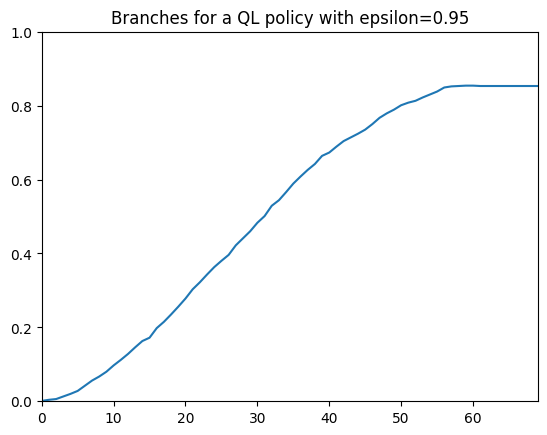

In [61]:
probes: int = 1000
_ = (
    calculate_board_branching(simulate_game(probes, (ql_policy1, ql_policy1))[0])
    / probes
).plot(
    ylim=(0, 1),
    xlim=(0, 69),
    title=f"Branches for a QL policy with epsilon={ql_policy1.epsilon}",
)

## Training some polices

### Defining some polices
In varius stages of this project varius Policies where created. Those compose of different values for exploration, reword fractions and gamma values and different network structures.

In [62]:
ql_policy1 = QLPolicy(
    0.92,
    neural_network=DQLSimple(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.9,
    who_won_fraction=0,
    final_score_fraction=1,
)
ql_policy1.policy_name

'QL-M-G09-WW00-FSF10-DQLSimple-MSELoss'

In [63]:
ql_policies = []

In [64]:
ql_policy1 = QLPolicy(
    0.92,
    neural_network=DQLSimple(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.9,
    who_won_fraction=0,
    final_score_fraction=1,
)
ql_policies.append(ql_policy1)
ql_policy1.policy_name

'QL-M-G09-WW00-FSF10-DQLSimple-MSELoss'

In [65]:
ql_policy2 = QLPolicy(
    0.92,
    neural_network=DQLSimple(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.8,
    who_won_fraction=0,
    final_score_fraction=1,
)
ql_policies.append(ql_policy2)
ql_policy2.policy_name

'QL-M-G08-WW00-FSF10-DQLSimple-MSELoss'

In [66]:
ql_policy3 = QLPolicy(
    0.92,
    neural_network=DQLSimple(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=1,
    who_won_fraction=0,
    final_score_fraction=1,
)
ql_policies.append(ql_policy3)
ql_policy3.policy_name

'QL-M-G10-WW00-FSF10-DQLSimple-MSELoss'

In [67]:
ql_policy4 = QLPolicy(
    0.92,
    neural_network=DQLSimple(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.9,
    who_won_fraction=1,
    final_score_fraction=0,
)
ql_policies.append(ql_policy4)
ql_policy4.policy_name

'QL-M-G09-WW10-FSF00-DQLSimple-MSELoss'

In [68]:
ql_policy5 = QLPolicy(
    0.95,
    neural_network=DQLSimple(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.9,
    who_won_fraction=0.3,
    final_score_fraction=0.3,
)
ql_policies.append(ql_policy5)
ql_policy5.policy_name

'QL-M-G09-WW03-FSF03-DQLSimple-MSELoss'

In [69]:
ql_policy6 = QLPolicy(
    0.95,
    neural_network=DQLSimple(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.92,
    who_won_fraction=0.3,
    final_score_fraction=0.65,
)
ql_policies.append(ql_policy6)
ql_policy6.policy_name

'QL-M-G09-WW03-FSF07-DQLSimple-MSELoss'

In [70]:
ql_policy7 = QLPolicy(
    0.95,
    neural_network=DQLSimple(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.92,
    who_won_fraction=0.2,
    final_score_fraction=0.65,
)
ql_policies.append(ql_policy7)
ql_policy7.policy_name

'QL-M-G09-WW02-FSF07-DQLSimple-MSELoss'

In [71]:
ql_policy8 = QLPolicy(
    0.92,
    neural_network=DQLNet(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.8,
    who_won_fraction=0,
    final_score_fraction=1,
)
ql_policies.append(ql_policy8)
ql_policy8.policy_name

'QL-M-G08-WW00-FSF10-DQLNet-MSELoss'

In [72]:
ql_policy9 = QLPolicy(
    0.92,
    neural_network=DQLNet(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=1,
    who_won_fraction=0,
    final_score_fraction=1,
)
ql_policies.append(ql_policy9)
ql_policy9.policy_name

'QL-M-G10-WW00-FSF10-DQLNet-MSELoss'

In [73]:
ql_policy10 = QLPolicy(
    0.92,
    neural_network=DQLNet(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.9,
    who_won_fraction=1,
    final_score_fraction=0,
)
ql_policies.append(ql_policy10)
ql_policy10.policy_name

'QL-M-G09-WW10-FSF00-DQLNet-MSELoss'

In [74]:
ql_policy11 = QLPolicy(
    0.95,
    neural_network=DQLNet(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.9,
    who_won_fraction=0.3,
    final_score_fraction=0.3,
)
ql_policies.append(ql_policy11)
ql_policy11.policy_name

'QL-M-G09-WW03-FSF03-DQLNet-MSELoss'

In [75]:
ql_policy12 = QLPolicy(
    0.95,
    neural_network=DQLNet(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.92,
    who_won_fraction=0.3,
    final_score_fraction=0.65,
)
ql_policies.append(ql_policy12)
ql_policy12.policy_name

'QL-M-G09-WW03-FSF07-DQLNet-MSELoss'

In [76]:
ql_policy13 = QLPolicy(
    0.95,
    neural_network=DQLNet(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.92,
    who_won_fraction=0.2,
    final_score_fraction=0.65,
)
ql_policies.append(ql_policy13)
ql_policy13.policy_name

'QL-M-G09-WW02-FSF07-DQLNet-MSELoss'

### Defining some metric polices

Since the ANN policies are in flux and change while trainig a continues comparison with unchanging policies is needed. The `RandomPolicy` and the `GreedyPolicy` fulfill that role.

In [77]:
constant_metric_policies = [RandomPolicy(0), GreedyPolicy(0)]

Below the training progress for the Q-Learning policy is shown.

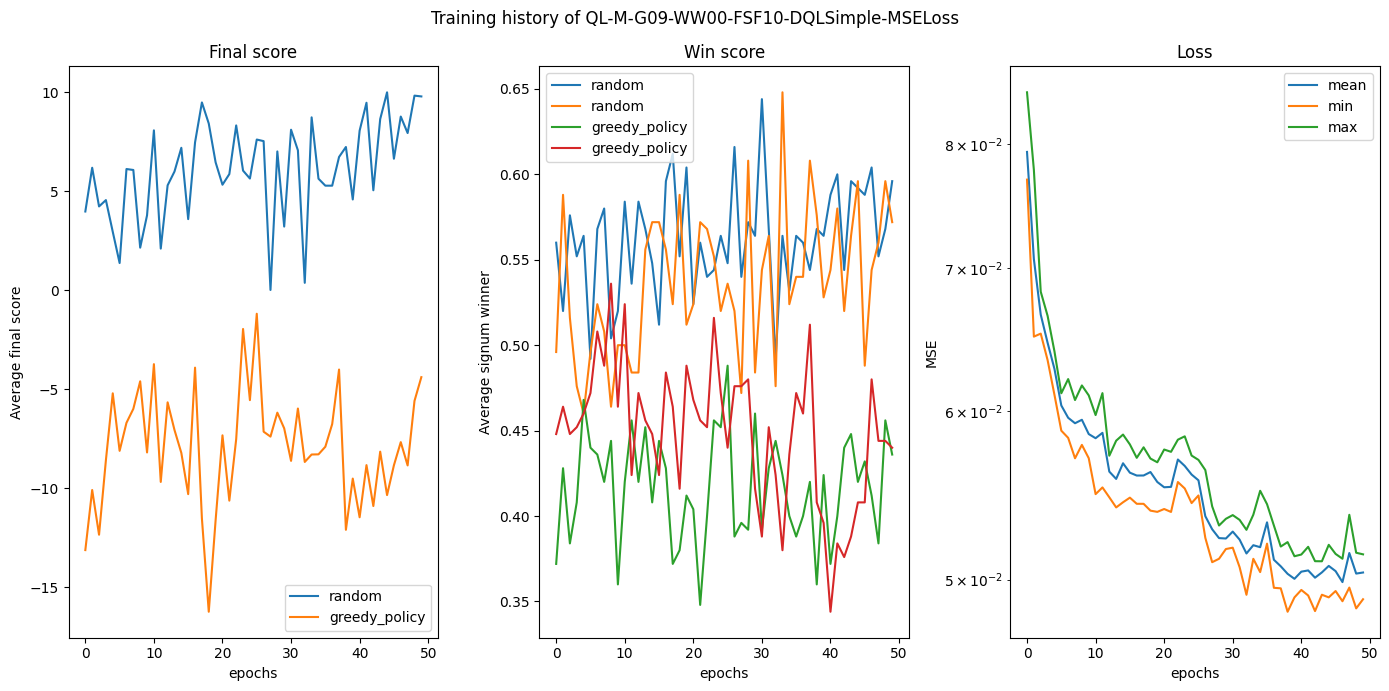

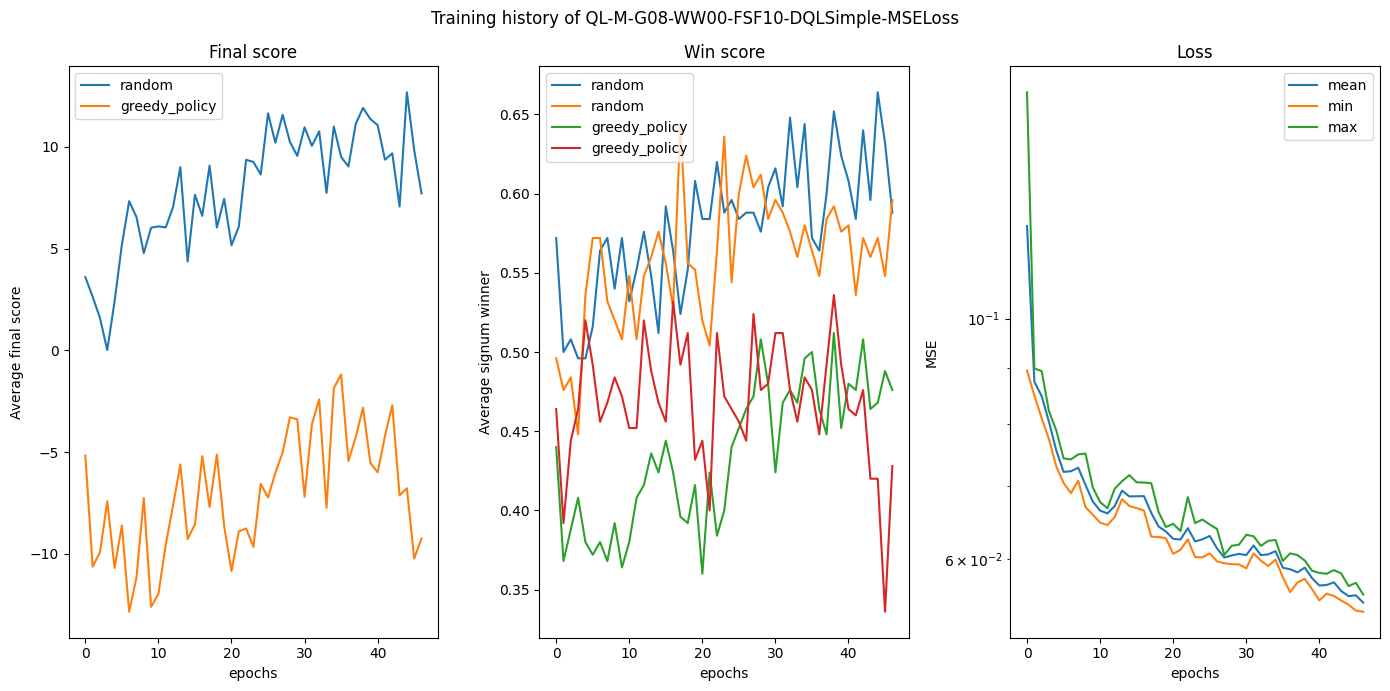

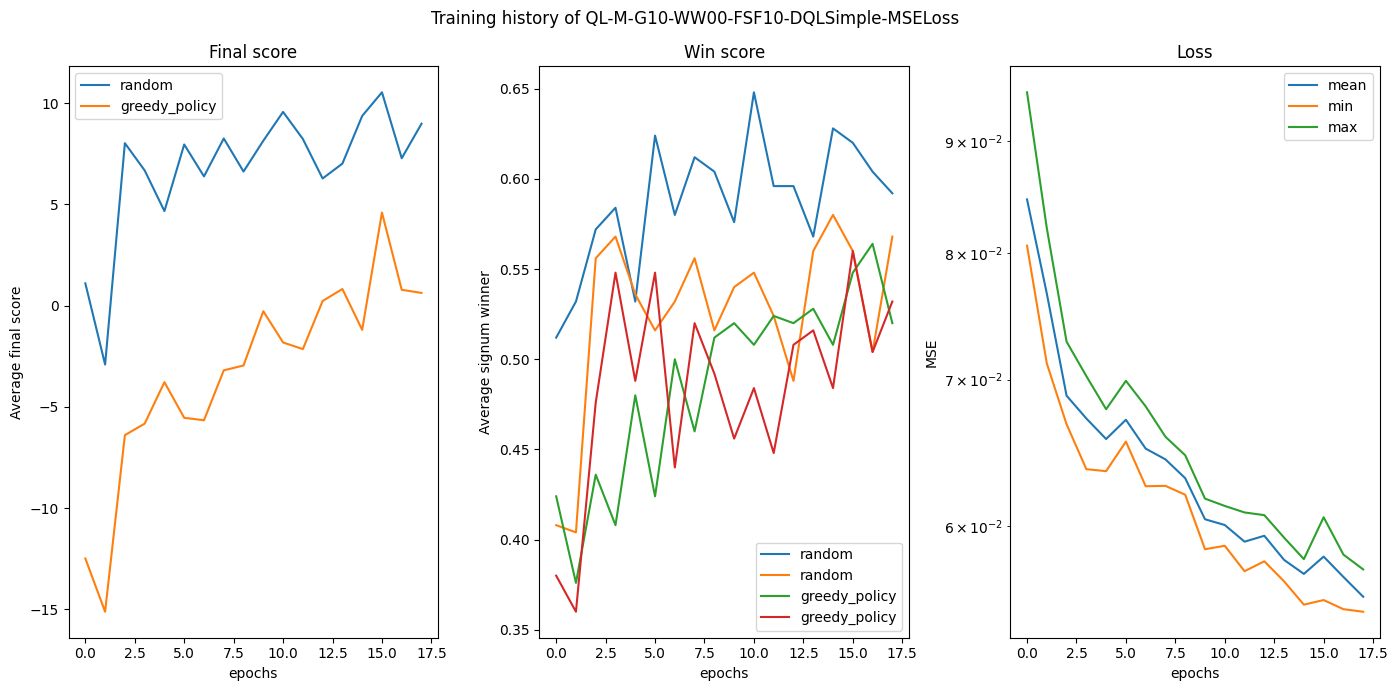

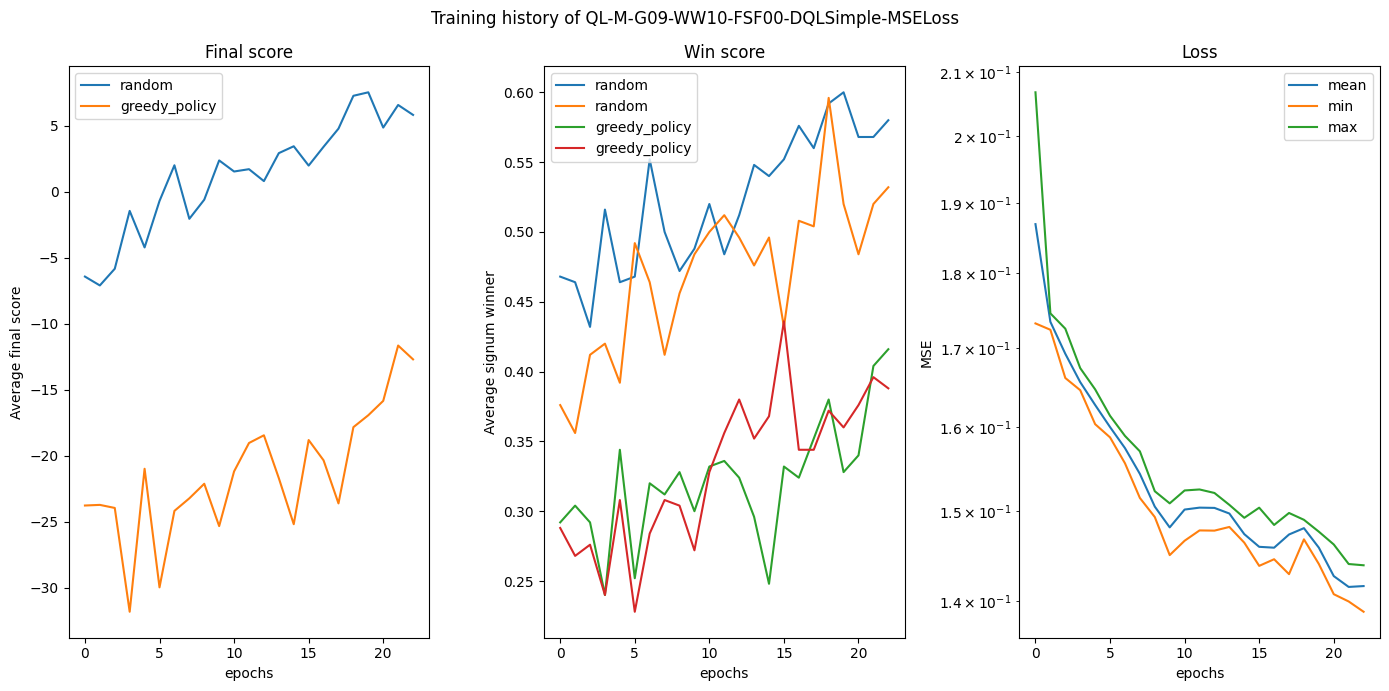

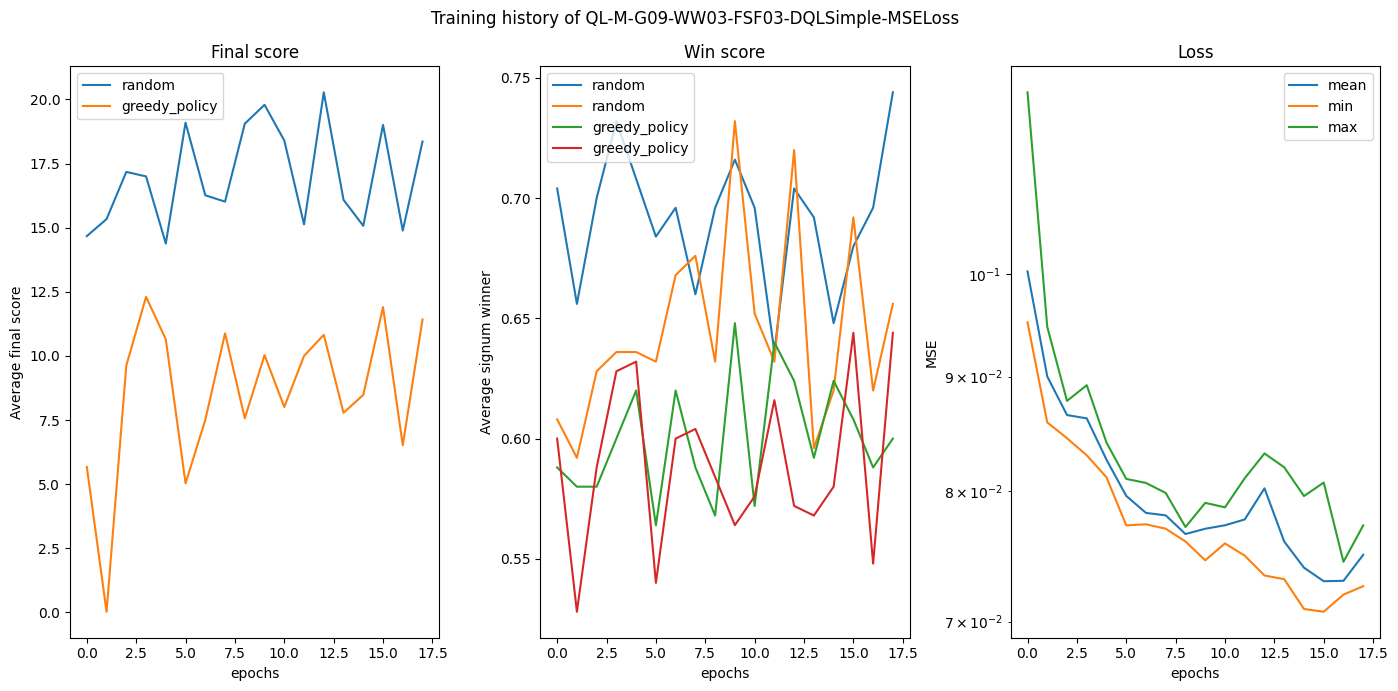

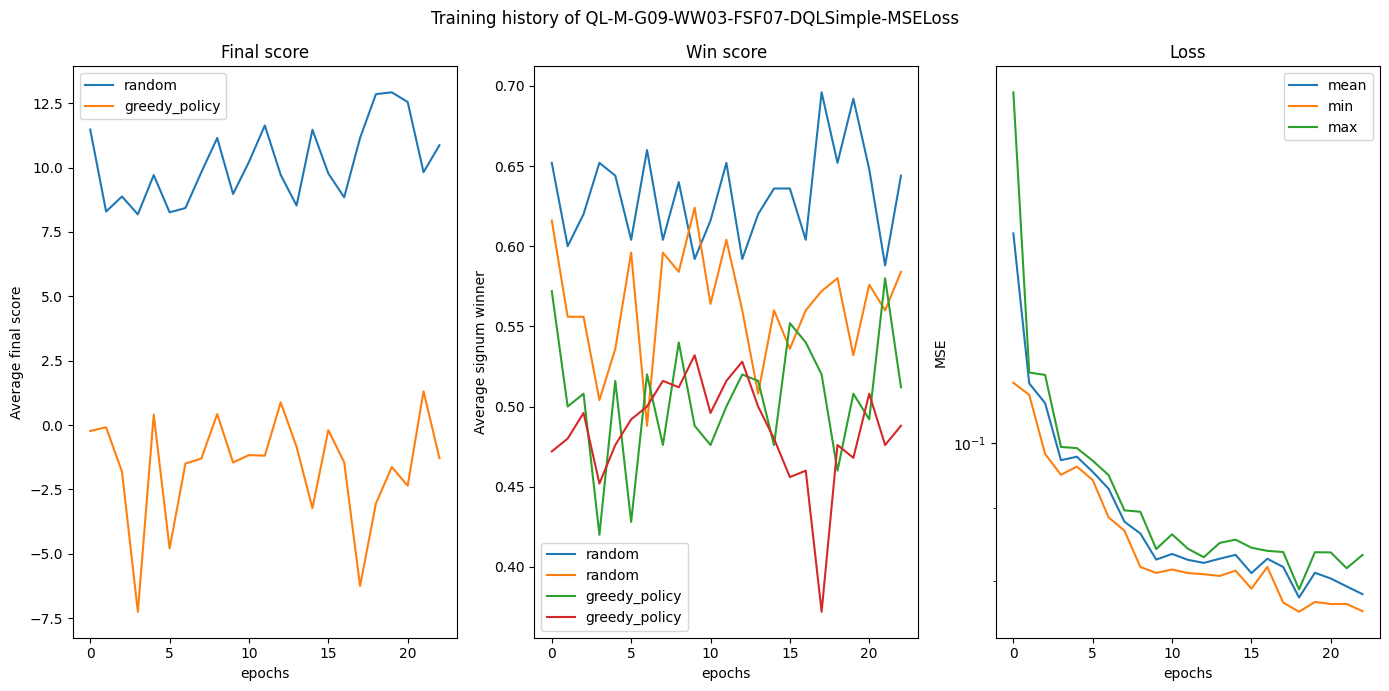

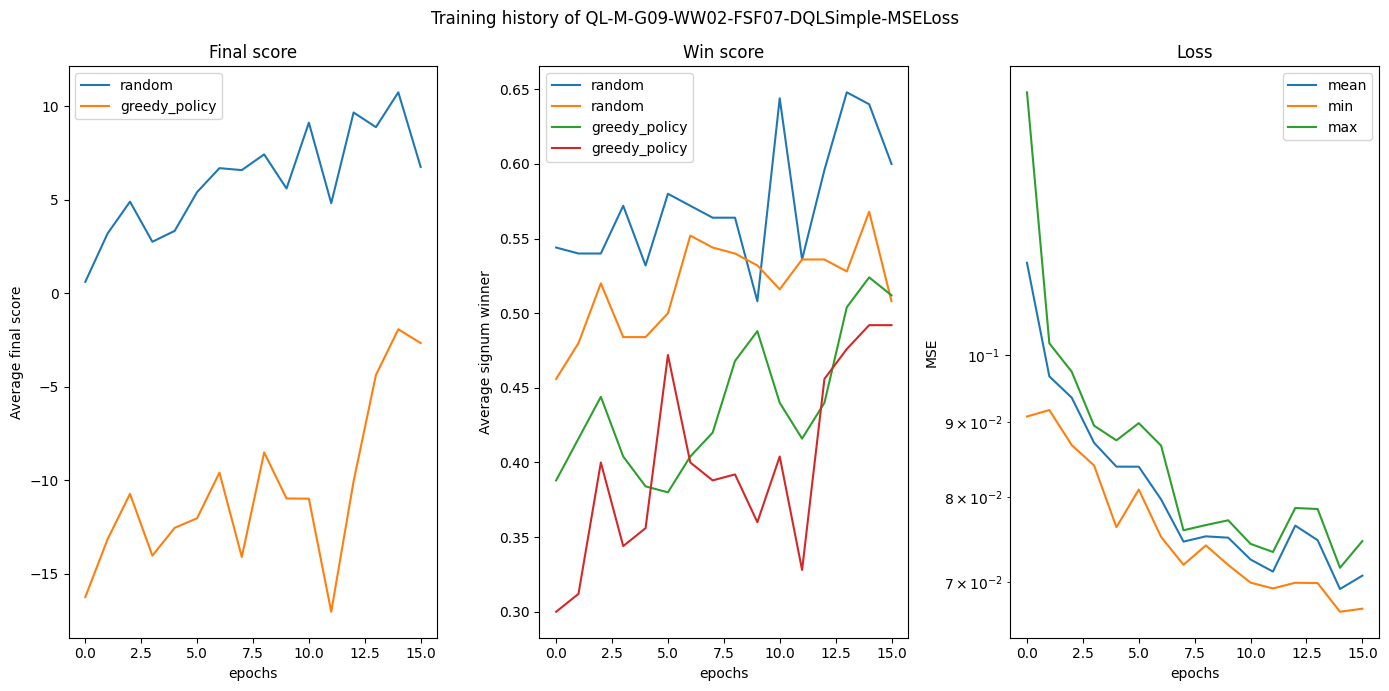

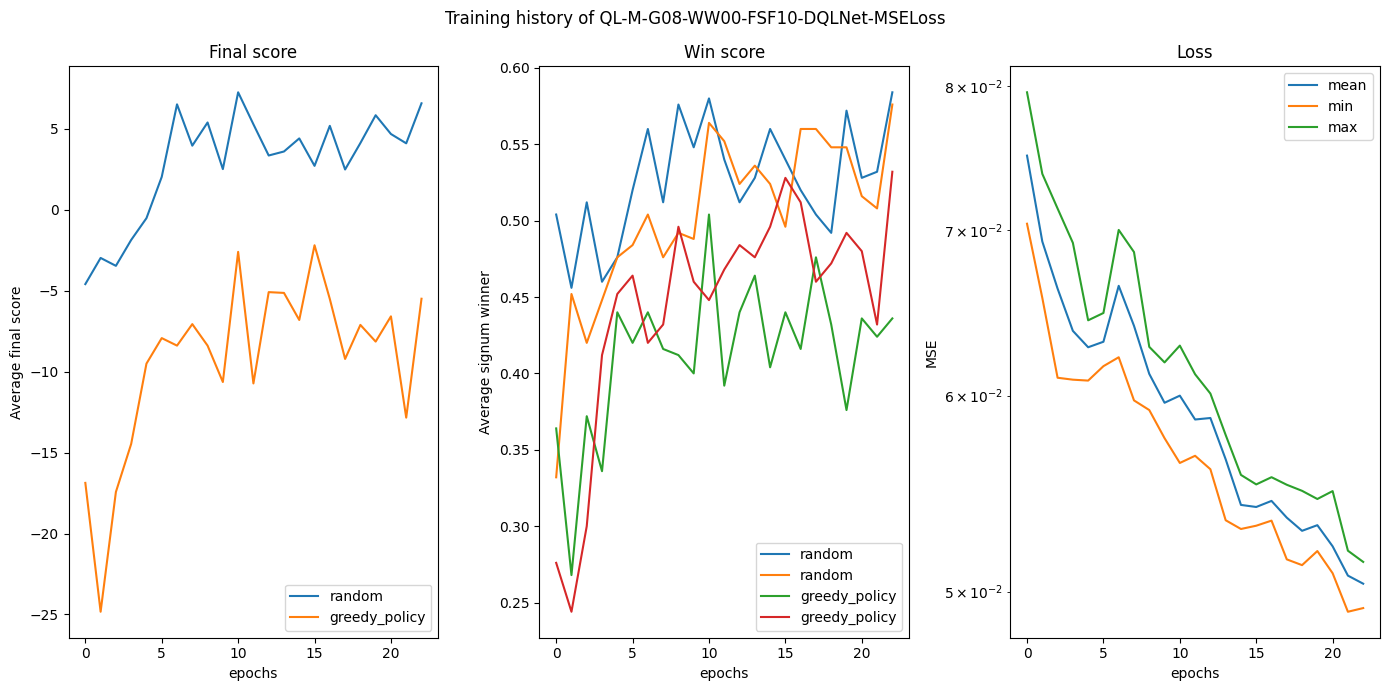

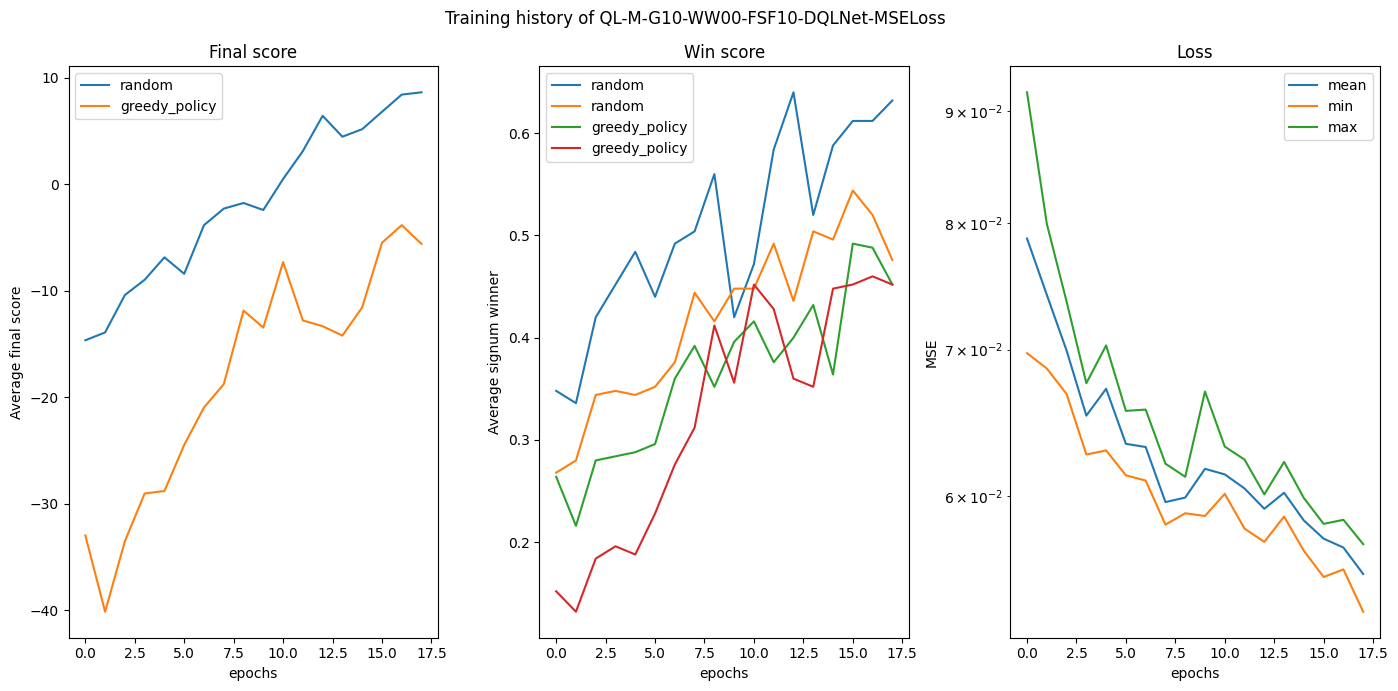

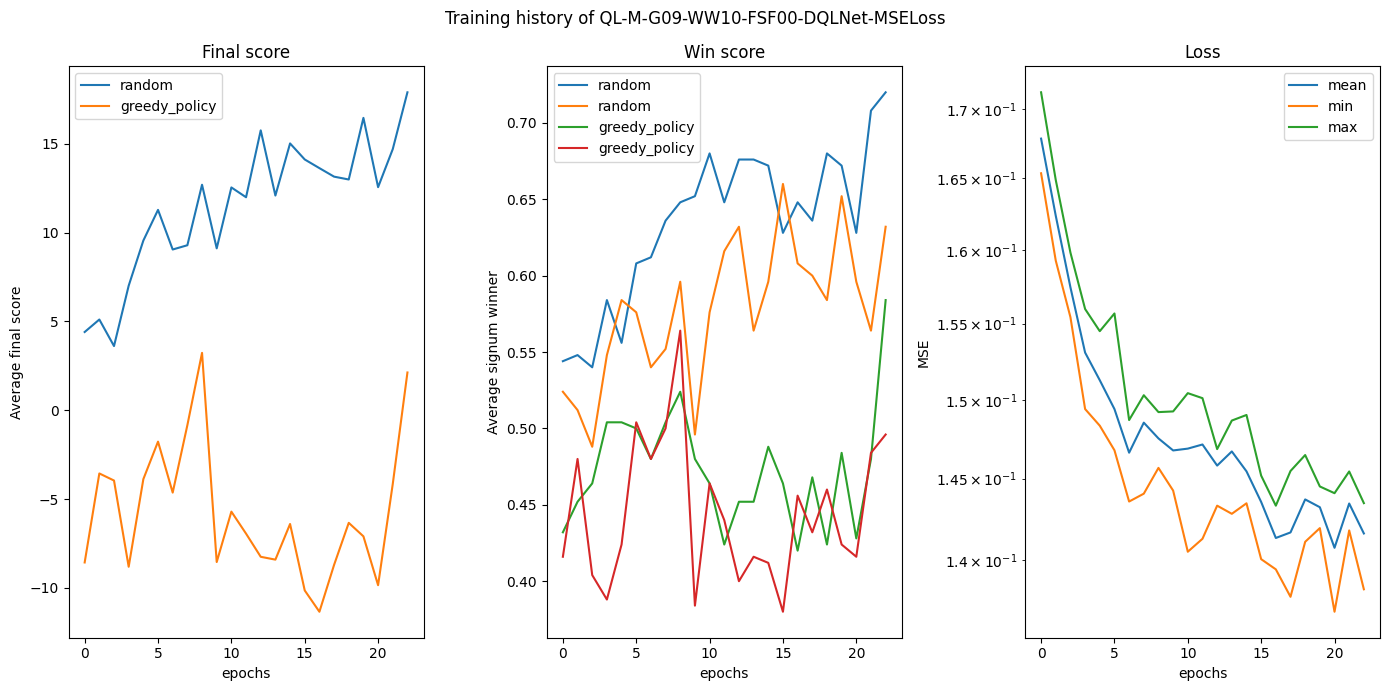

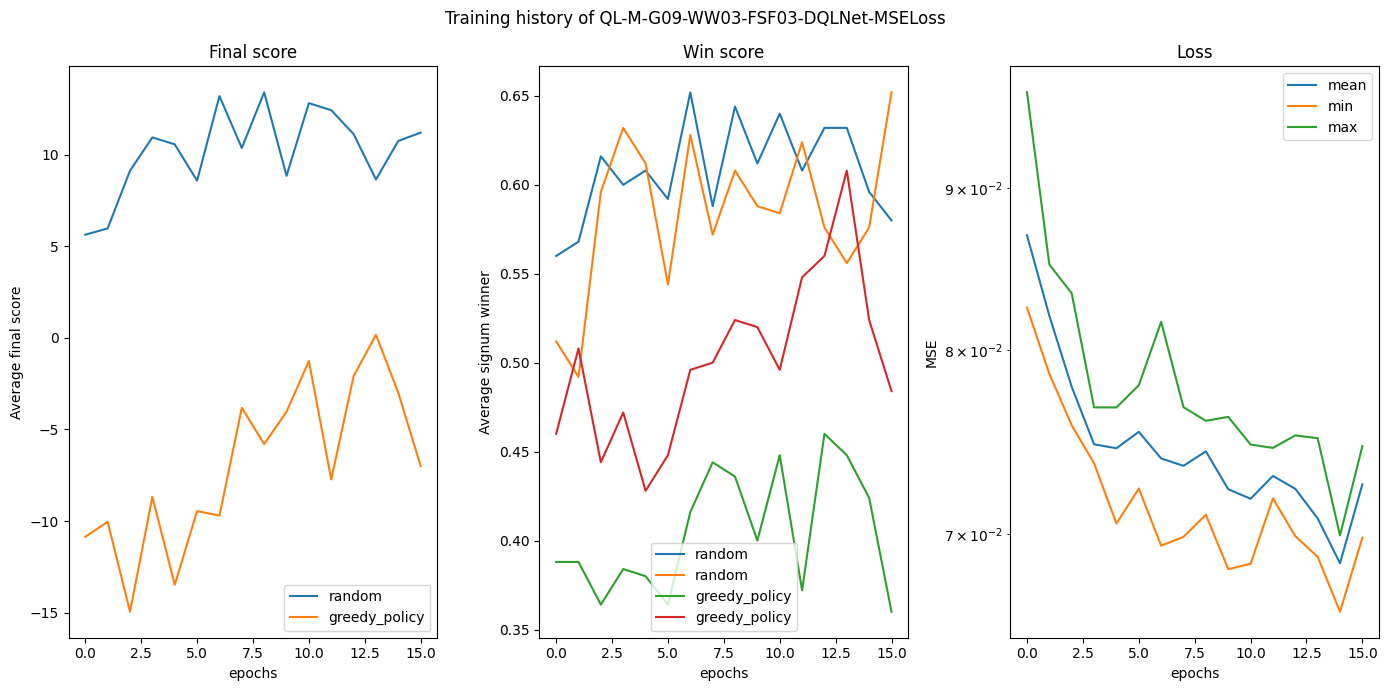

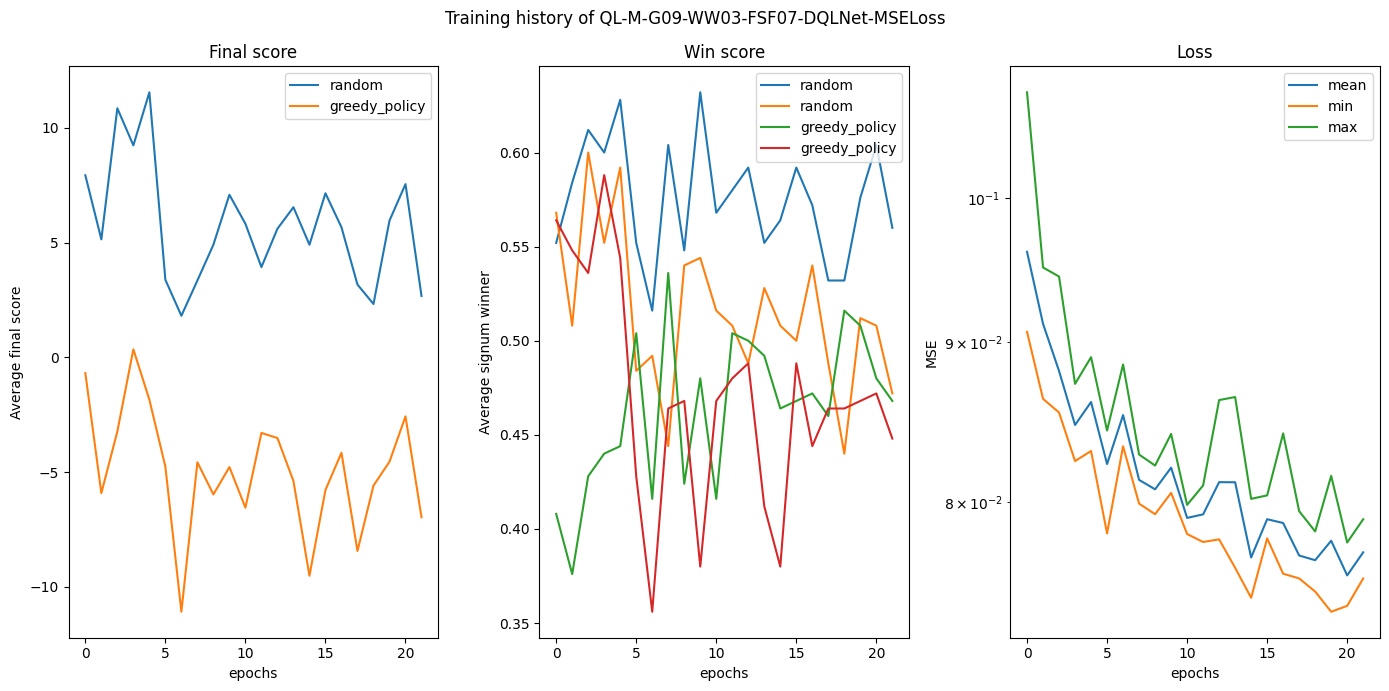

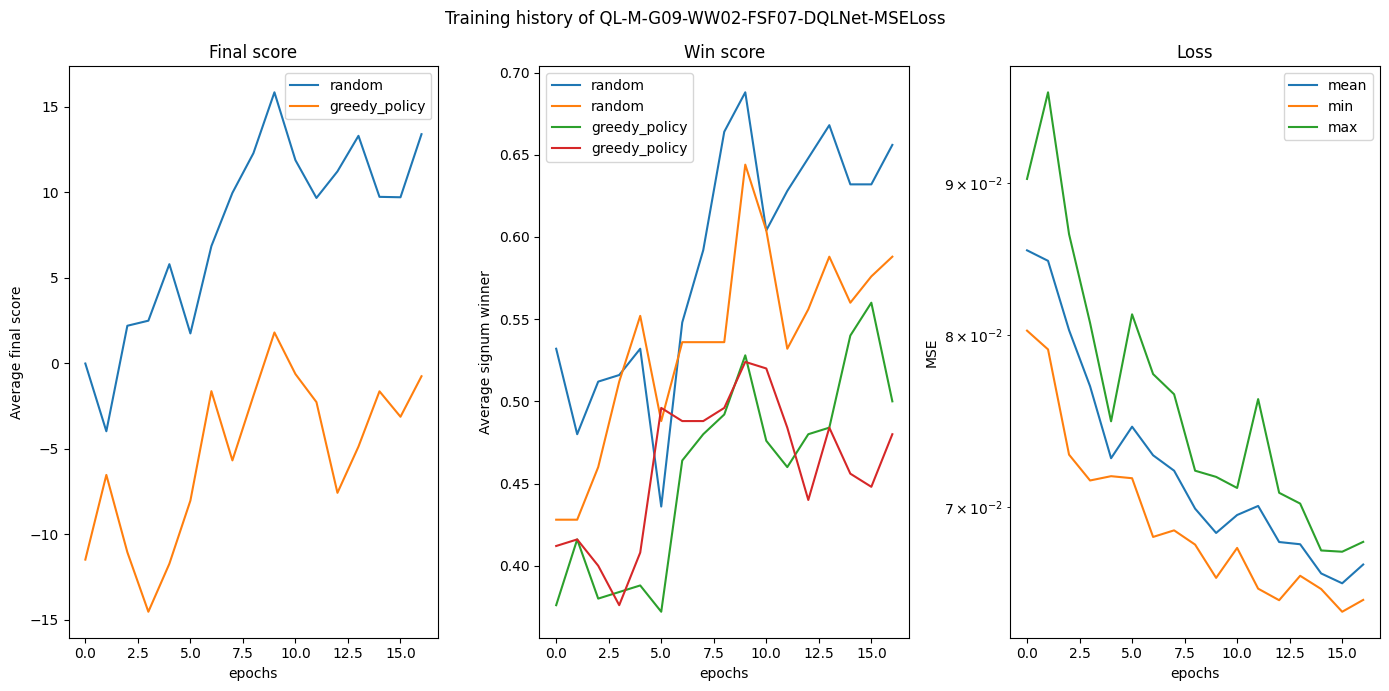

In [78]:
for ql_policy in ql_policies:
    ql_policy.load()
    ql_policy.plot_history()

The training consistency varies from policy to policy, with some policies being more stable and exhibiting less variation. Moreover, the highly interdependent metrics indicate that the evaluation sample size may be too small.

Since batch size and metrics have similar sizes this suggests that the batch size should also be increased. Sadly with the current Q-Learning setup this is not possible due to CPU constraints.

### Example simulations

The section below shows the trained policies, playing as black against a white opponent.
The Policy can be chosen via the dropdown menu.

In [225]:
@interact(ql_policy=ql_policies)
def plot_policy_example(ql_policy):
    ql_policy.load()
    np.random.seed(1)
    ql_policy = copy.copy(ql_policy)
    ql_policy.epsilon = 1
    simulation_results = simulate_game(1, (ql_policy, RandomPolicy(0)))
    _unique_bords, _unique_actions = drop_duplicate_boards(
        simulation_results[0].reshape(-1, 8, 8), simulation_results[1].reshape(-1, 2)
    )
    plot_othello_boards(_unique_bords, actions=_unique_actions)
    plt.show()

interactive(children=(Dropdown(description='ql_policy', options=(QL-M-G09-WW00-FSF10-DQLSimple-MSELoss, QL-M-G…

For some analysis we need a specially good policy. Normally 

In [211]:
example_policy = ql_policies[4]
example_policy

QL-M-G09-WW03-FSF03-DQLSimple-MSELoss

## Analysis of the Policies

When creating such policies it is necessary to evaluate the results. One way of doing so is to play a huge tournament where all Policies cross paths at least twice.
The resulting dataframe contains the results as a json where on the index the first policy is noted and the second by the column.
This allows for different metrics for all the policies while simulating them only once.

In [206]:
policy_list = constant_metric_policies + ql_policies

RESULTS_FILE: Final[str] = "results.pickle"
if not os.path.exists(RESULTS_FILE):
    result_df = pd.DataFrame(
        index=[policy.policy_name for policy in policy_list],
        columns=[policy.policy_name for policy in policy_list],
    )
else:
    result_df = pd.read_pickle(RESULTS_FILE)

nr_of_eval_games = 250

for policy1, policy2 in tqdm(list(itertools.product(policy_list, policy_list))):
    if not pd.isna(result_df.at[policy1.policy_name, policy2.policy_name]):
        continue
    _result_dict = {}
    policy1 = copy.copy(policy1)
    policy1.epsilon = 0.99
    policy2 = copy.copy(policy2)
    policy2.epsilon = 0.99
    _boards_black, _ = simulate_game(nr_of_eval_games, (policy1, policy2))
    _win_eval_black = calculate_who_won(_boards_black)
    _result_dict["final_score"] = float(
        np.mean(calculate_final_evaluation_for_history(_boards_black))
    )
    _result_dict["win"] = np.sum(_win_eval_black == 1) / nr_of_eval_games
    _result_dict["lose"] = np.sum(_win_eval_black == -1) / nr_of_eval_games
    result_df.at[policy1.policy_name, policy2.policy_name] = _result_dict
    result_df.to_pickle(RESULTS_FILE)
result_df.index.name = "Black policy"
result_df.columns.name = "White policy"

  0%|          | 0/225 [00:00<?, ?it/s]

### Analysing the policy by the win score
The table presented below displays the win ratio for each color, providing directional insight into how one policy played against the other as black or white. While most values are positive, indicating that the player who played as black had an advantage, this bias could not be overcome with the current architecture. Nonetheless, the table does demonstrate some learning behavior.

In [207]:
df = result_df.applymap(lambda x: x["win"])
df

White policy                           random  greedy_policy  \
Black policy                                                   
random                                  0.432          0.376   
greedy_policy                           0.592          0.488   
QL-M-G09-WW00-FSF10-DQLSimple-MSELoss   0.592          0.456   
QL-M-G08-WW00-FSF10-DQLSimple-MSELoss   0.616          0.384   
QL-M-G10-WW00-FSF10-DQLSimple-MSELoss   0.580          0.532   
QL-M-G09-WW10-FSF00-DQLSimple-MSELoss   0.520          0.340   
QL-M-G09-WW03-FSF03-DQLSimple-MSELoss   0.628          0.616   
QL-M-G09-WW03-FSF07-DQLSimple-MSELoss   0.576          0.528   
QL-M-G09-WW02-FSF07-DQLSimple-MSELoss   0.524          0.404   
QL-M-G08-WW00-FSF10-DQLNet-MSELoss      0.492          0.452   
QL-M-G10-WW00-FSF10-DQLNet-MSELoss      0.552          0.436   
QL-M-G09-WW10-FSF00-DQLNet-MSELoss      0.660          0.492   
QL-M-G09-WW03-FSF03-DQLNet-MSELoss      0.560          0.496   
QL-M-G09-WW03-FSF07-DQLNet-MSELoss      0.504          0.488   
QL-M-G09-WW02-FSF07-DQLNet-MSELoss      0.608          0.512   

White policy                           QL-M-G09-WW00-FSF10-DQLSimple-MSELoss  \
Black policy                                                                   
random                                                                 0.340   
greedy_policy                                                          0.596   
QL-M-G09-WW00-FSF10-DQLSimple-MSELoss                                  0.856   
QL-M-G08-WW00-FSF10-DQLSimple-MSELoss                                  0.852   
QL-M-G10-WW00-FSF10-DQLSimple-MSELoss                                  0.796   
QL-M-G09-WW10-FSF00-DQLSimple-MSELoss                                  0.820   
QL-M-G09-WW03-FSF03-DQLSimple-MSELoss                                  0.756   
QL-M-G09-WW03-FSF07-DQLSimple-MSELoss                                  0.144   
QL-M-G09-WW02-FSF07-DQLSimple-MSELoss                                  0.876   
QL-M-G08-WW00-FSF10-DQLNet-MSELoss                                     0.112   
QL-M-G10-WW00-FSF10-DQLNet-MSELoss                                     0.832   
QL-M-G09-WW10-FSF00-DQLNet-MSELoss                                     0.784   
QL-M-G09-WW03-FSF03-DQLNet-MSELoss                                     0.728   
QL-M-G09-WW03-FSF07-DQLNet-MSELoss                                     0.108   
QL-M-G09-WW02-FSF07-DQLNet-MSELoss                                     0.836   

White policy                           QL-M-G08-WW00-FSF10-DQLSimple-MSELoss  \
Black policy                                                                   
random                                                                 0.312   
greedy_policy                                                          0.392   
QL-M-G09-WW00-FSF10-DQLSimple-MSELoss                                  0.172   
QL-M-G08-WW00-FSF10-DQLSimple-MSELoss                                  0.792   
QL-M-G10-WW00-FSF10-DQLSimple-MSELoss                                  0.772   
QL-M-G09-WW10-FSF00-DQLSimple-MSELoss                                  0.868   
QL-M-G09-WW03-FSF03-DQLSimple-MSELoss                                  0.124   
QL-M-G09-WW03-FSF07-DQLSimple-MSELoss                                  0.800   
QL-M-G09-WW02-FSF07-DQLSimple-MSELoss                                  0.704   
QL-M-G08-WW00-FSF10-DQLNet-MSELoss                                     0.128   
QL-M-G10-WW00-FSF10-DQLNet-MSELoss                                     0.136   
QL-M-G09-WW10-FSF00-DQLNet-MSELoss                                     0.792   
QL-M-G09-WW03-FSF03-DQLNet-MSELoss                                     0.044   
QL-M-G09-WW03-FSF07-DQLNet-MSELoss                                     0.100   
QL-M-G09-WW02-FSF07-DQLNet-MSELoss                                     0.884   

White policy                           QL-M-G10-WW00-FSF10-DQLSimple-MSELoss  \
Black policy                                                                   
random                       

To mitigate the bias in the matrix, we calculate a perspective-correct mean by subtracting its transposed version and dividing by two. This compensates for the black policy's relative advantage. However, the resulting values may not all be positive, as some policies may now have a negative average win signum. Specifically, a policy with a win signum of 0.1 will win 60% of the games.

Despite this, we observe that learning did occur, as most games played against the random and greedy policies resulted in a positive score. However, the degree of learning fell far short of our expectations. A simple policy that weights each stone by its position may be much more effective, particularly if the value trends towards 1 towards the end of the game. This aligns with our earlier observations.

In [208]:
df = result_df.applymap(lambda x: x["win"])
(df - df.T) / 2

White policy                           random  greedy_policy  \
Black policy                                                   
random                                  0.000         -0.108   
greedy_policy                           0.108          0.000   
QL-M-G09-WW00-FSF10-DQLSimple-MSELoss   0.126         -0.070   
QL-M-G08-WW00-FSF10-DQLSimple-MSELoss   0.152         -0.004   
QL-M-G10-WW00-FSF10-DQLSimple-MSELoss   0.106          0.040   
QL-M-G09-WW10-FSF00-DQLSimple-MSELoss   0.088         -0.102   
QL-M-G09-WW03-FSF03-DQLSimple-MSELoss   0.192          0.116   
QL-M-G09-WW03-FSF07-DQLSimple-MSELoss   0.122          0.046   
QL-M-G09-WW02-FSF07-DQLSimple-MSELoss   0.106         -0.040   
QL-M-G08-WW00-FSF10-DQLNet-MSELoss      0.020         -0.042   
QL-M-G10-WW00-FSF10-DQLNet-MSELoss      0.090         -0.018   
QL-M-G09-WW10-FSF00-DQLNet-MSELoss      0.194          0.030   
QL-M-G09-WW03-FSF03-DQLNet-MSELoss      0.104         -0.042   
QL-M-G09-WW03-FSF07-DQLNet-MSELoss      0.058         -0.010   
QL-M-G09-WW02-FSF07-DQLNet-MSELoss      0.126          0.034   

White policy                           QL-M-G09-WW00-FSF10-DQLSimple-MSELoss  \
Black policy                                                                   
random                                                                -0.126   
greedy_policy                                                          0.070   
QL-M-G09-WW00-FSF10-DQLSimple-MSELoss                                  0.000   
QL-M-G08-WW00-FSF10-DQLSimple-MSELoss                                  0.340   
QL-M-G10-WW00-FSF10-DQLSimple-MSELoss                                  0.024   
QL-M-G09-WW10-FSF00-DQLSimple-MSELoss                                  0.372   
QL-M-G09-WW03-FSF03-DQLSimple-MSELoss                                  0.310   
QL-M-G09-WW03-FSF07-DQLSimple-MSELoss                                 -0.308   
QL-M-G09-WW02-FSF07-DQLSimple-MSELoss                                  0.350   
QL-M-G08-WW00-FSF10-DQLNet-MSELoss                                    -0.012   
QL-M-G10-WW00-FSF10-DQLNet-MSELoss                                     0.364   
QL-M-G09-WW10-FSF00-DQLNet-MSELoss                                     0.344   
QL-M-G09-WW03-FSF03-DQLNet-MSELoss                                    -0.038   
QL-M-G09-WW03-FSF07-DQLNet-MSELoss                                    -0.400   
QL-M-G09-WW02-FSF07-DQLNet-MSELoss                                     0.058   

White policy                           QL-M-G08-WW00-FSF10-DQLSimple-MSELoss  \
Black policy                                                                   
random                                                                -0.152   
greedy_policy                                                          0.004   
QL-M-G09-WW00-FSF10-DQLSimple-MSELoss                                 -0.340   
QL-M-G08-WW00-FSF10-DQLSimple-MSELoss                                  0.000   
QL-M-G10-WW00-FSF10-DQLSimple-MSELoss                                 -0.030   
QL-M-G09-WW10-FSF00-DQLSimple-MSELoss                                  0.354   
QL-M-G09-WW03-FSF03-DQLSimple-MSELoss                                 -0.344   
QL-M-G09-WW03-FSF07-DQLSimple-MSELoss                                  0.344   
QL-M-G09-WW02-FSF07-DQLSimple-MSELoss                                  0.308   
QL-M-G08-WW00-FSF10-DQLNet-MSELoss                                    -0.048   
QL-M-G10-WW00-FSF10-DQLNet-MSELoss                                    -0.304   
QL-M-G09-WW10-FSF00-DQLNet-MSELoss                                     0.358   
QL-M-G09-WW03-FSF03-DQLNet-MSELoss                                    -0.392   
QL-M-G09-WW03-FSF07-DQLNet-MSELoss                                    -0.328   
QL-M-G09-WW02-FSF07-DQLNet-MSELoss                                     0.388   

White policy                           QL-M-G10-WW00-FSF10-DQLSimple-MSELoss  \
Black policy                                                                   
random                       

Sadly there is no clear best policy to identify.

### Analysing the polices by the final score
When analysing the final score it is also not easy to see any QL-policy clearly outpacing the other QL-policies.
Score color bias compensation is done the same as above. The multiplication by 64 compensates for the score beeing normed to [1, -1]. The score now calculates the advantage in points a player has.

In [327]:
df = result_df.applymap(lambda x: x["final_score"])
(df - df.T) / 2 * 64

White policy                           random  greedy_policy  \
Black policy                                                   
random                                  0.000         -7.828   
greedy_policy                           7.828          0.000   
QL-M-G09-WW00-FSF10-DQLSimple-MSELoss   6.020         -4.028   
QL-M-G08-WW00-FSF10-DQLSimple-MSELoss   6.652         -3.084   
QL-M-G10-WW00-FSF10-DQLSimple-MSELoss   3.832         -0.472   
QL-M-G09-WW10-FSF00-DQLSimple-MSELoss   3.400         -7.428   
QL-M-G09-WW03-FSF03-DQLSimple-MSELoss   8.016          2.200   
QL-M-G09-WW03-FSF07-DQLSimple-MSELoss   6.296          0.392   
QL-M-G09-WW02-FSF07-DQLSimple-MSELoss   5.636         -2.752   
QL-M-G08-WW00-FSF10-DQLNet-MSELoss      0.800         -4.560   
QL-M-G10-WW00-FSF10-DQLNet-MSELoss      4.208         -2.292   
QL-M-G09-WW10-FSF00-DQLNet-MSELoss      8.928         -0.216   
QL-M-G09-WW03-FSF03-DQLNet-MSELoss      5.372         -4.748   
QL-M-G09-WW03-FSF07-DQLNet-MSELoss      2.976         -1.404   
QL-M-G09-WW02-FSF07-DQLNet-MSELoss      6.084         -0.240   

White policy                           QL-M-G09-WW00-FSF10-DQLSimple-MSELoss  \
Black policy                                                                   
random                                                                -6.020   
greedy_policy                                                          4.028   
QL-M-G09-WW00-FSF10-DQLSimple-MSELoss                                  0.000   
QL-M-G08-WW00-FSF10-DQLSimple-MSELoss                                 14.176   
QL-M-G10-WW00-FSF10-DQLSimple-MSELoss                                  2.912   
QL-M-G09-WW10-FSF00-DQLSimple-MSELoss                                 11.464   
QL-M-G09-WW03-FSF03-DQLSimple-MSELoss                                  5.176   
QL-M-G09-WW03-FSF07-DQLSimple-MSELoss                                 -9.160   
QL-M-G09-WW02-FSF07-DQLSimple-MSELoss                                 12.136   
QL-M-G08-WW00-FSF10-DQLNet-MSELoss                                    -0.924   
QL-M-G10-WW00-FSF10-DQLNet-MSELoss                                    14.460   
QL-M-G09-WW10-FSF00-DQLNet-MSELoss                                    13.608   
QL-M-G09-WW03-FSF03-DQLNet-MSELoss                                    -1.912   
QL-M-G09-WW03-FSF07-DQLNet-MSELoss                                   -13.204   
QL-M-G09-WW02-FSF07-DQLNet-MSELoss                                     3.764   

White policy                           QL-M-G08-WW00-FSF10-DQLSimple-MSELoss  \
Black policy                                                                   
random                                                                -6.652   
greedy_policy                                                          3.084   
QL-M-G09-WW00-FSF10-DQLSimple-MSELoss                                -14.176   
QL-M-G08-WW00-FSF10-DQLSimple-MSELoss                                  0.000   
QL-M-G10-WW00-FSF10-DQLSimple-MSELoss                                 -3.460   
QL-M-G09-WW10-FSF00-DQLSimple-MSELoss                                  7.600   
QL-M-G09-WW03-FSF03-DQLSimple-MSELoss                                -10.820   
QL-M-G09-WW03-FSF07-DQLSimple-MSELoss                                 20.352   
QL-M-G09-WW02-FSF07-DQLSimple-MSELoss                                  9.228   
QL-M-G08-WW00-FSF10-DQLNet-MSELoss                                   -12.092   
QL-M-G10-WW00-FSF10-DQLNet-MSELoss                                   -12.940   
QL-M-G09-WW10-FSF00-DQLNet-MSELoss                                    13.204   
QL-M-G09-WW03-FSF03-DQLNet-MSELoss                                   -12.212   
QL-M-G09-WW03-FSF07-DQLNet-MSELoss                                   -12.672   
QL-M-G09-WW02-FSF07-DQLNet-MSELoss                                    16.348   

White policy                           QL-M-G10-WW00-FSF10-DQLSimple-MSELoss  \
Black policy                                                                   
random                       

There is no clear best policy to identify.

### Analysing the corner behavior

Given the importance of corner capture in Othello strategies, it is worth investigating if the Policies discover this on their own. To analyze this behavior, we selected a policy and measured the availability of corners, the probability of a corner stone being available, and the number of corners captured by the AI when playing against a random player.

In [205]:
example_policy

QL-M-G09-WW00-FSF10-DQLSimple-MSELoss

In [168]:
_l_board_history, _l_action_history = simulate_game(
    1000, (example_policy, RandomPolicy(1)), True
)
_r_board_history, _r_action_history = simulate_game(
    1000, (RandomPolicy(1), example_policy), True
)

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

In [170]:
_l_actions_possible = get_possible_turns(_l_board_history.reshape(-1, 8, 8)).reshape(
    (70, -1, 8, 8)
)
_r_actions_possible = get_possible_turns(_r_board_history.reshape(-1, 8, 8)).reshape(
    (70, -1, 8, 8)
)


_l_mean_actions_possible = np.mean(_l_actions_possible, axis=1)
_r_mean_actions_possible = np.mean(_r_actions_possible, axis=1)

((70, 8, 8), (70, 8, 8))

#### Corner stone analysis via possible action space
As noted in the analysis of the game and its behavior over time a heat map can be used to calculate how a game was won compared to a random strategy.

In [180]:
@interact(turn=(0, 69))
def turn_distribution_heatmap(turn):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    l_turn_possibility_on_field = _l_mean_actions_possible[turn]
    r_turn_possibility_on_field = _r_mean_actions_possible[turn]
    turn_possibility_on_field = mean_poss_turn[turn]

    vmax = max(
        np.max(l_turn_possibility_on_field),
        np.max(r_turn_possibility_on_field),
        np.max(turn_possibility_on_field),
    )

    sns.heatmap(
        turn_possibility_on_field,
        linewidth=0.5,
        square=True,
        annot=True,
        xticklabels="ABCDEFGH",
        yticklabels=list(range(1, 9)),
        ax=ax2,
        vmax=vmax,
    )
    ax2.set_title("For a random player")

    sns.heatmap(
        l_turn_possibility_on_field,
        linewidth=0.5,
        square=True,
        annot=True,
        xticklabels="ABCDEFGH",
        yticklabels=list(range(1, 9)),
        ax=ax1,
        vmax=vmax,
    )
    ax1.set_title("The trained policy for the player (black)")

    sns.heatmap(
        r_turn_possibility_on_field,
        linewidth=0.5,
        square=True,
        annot=True,
        xticklabels="ABCDEFGH",
        yticklabels=list(range(1, 9)),
        ax=ax3,
        vmax=vmax,
    )
    ax3.set_title("The trained policy for the enemy (white)")
    fig.suptitle(f"Headmap of where stones can be placed on turn {turn}")
    plt.tight_layout()

interactive(children=(IntSlider(value=34, description='turn', max=69), Output()), _dom_classes=('widget-intera…

The analysis reveals that the chance of capturing a cornerstone is significantly higher when playing against a random player compared to playing against the trained policy. This is because the trained policy understands the importance of cornerstones and tends to capture them faster, while also avoiding giving the same opportunity to the opponent.

Another way to demonstrate this is by visualizing the mean chance of capturing one of the four cornerstones over time, as shown in the plot below. This provides a compact representation of the trend over time.

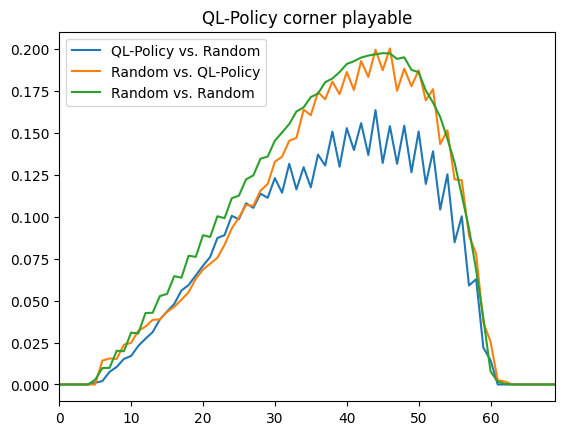

In [292]:
a = np.mean(_l_mean_actions_possible[:, [0, -1]][:, :, [0, -1]], axis=(1, 2))
b = np.mean(_r_mean_actions_possible[:, [0, -1]][:, :, [0, -1]], axis=(1, 2))
c = np.mean(mean_poss_turn[:, [0, -1]][:, :, [0, -1]], axis=(1, 2))

df = pd.DataFrame(
    [a, b, c],
    index=["QL-Policy vs. Random", "Random vs. QL-Policy", "Random vs. Random"],
).T.plot(title="QL-Policy corner playable", xlim=(0, 69))

#### Corner stone capture count
When counting the number of corners captured, it's evident that the QL policy has some understanding of their importance. However, since the result is not absolutely dependent on those corners it can't be concluded that they should be overly prioritized, and an outcome around 3 would have been expected. The average of 2.7 corners captured at the end of the game, though not very high, shows a positive trend.

In [328]:
a = np.sum(np.mean(_l_board_history[-1][:, [0, -1]][:, :, [0, -1]], axis=0))
b = -np.sum(np.mean(_r_board_history[-1][:, [0, -1]][:, :, [0, -1]], axis=0))
c = np.sum(np.mean(_board_history[-1][:, [0, -1]][:, :, [0, -1]], axis=0))

(
    pd.Series(
        [a, b, c],
        index=["QL-Policy vs. Random", "Random vs. QL-Policy", "Random vs. Random"],
    )
    + 2
)

QL-Policy vs. Random    2.748
Random vs. QL-Policy    2.507
Random vs. Random       1.952
dtype: float64

### Time till capture

An additional aspect to analyze is the time it takes to capture a corner when it becomes available. As capturing a corner is critical in Othello strategy, it is expected that the AI would priorities its capture. However, since the opponent is usually not able to capture the same corner at the same moment, the AI may not need to hurry. To test this hypothesis, we measured the time it took for the AI to capture a corner and compared it to the time it took for the AI to capture a non-corner cell. The results showed that the AI captured corners faster, although not by as much as expected.

In [322]:
pd.Series(
    {
        "QL-Policy vs. Random": np.mean(
            np.sum(_l_actions_possible[::2], axis=0)[:, [0, -1]][:, :, [0, -1]]
        ),
        "Random vs. QL-Policy": np.mean(
            np.sum(_r_actions_possible[1::2], axis=0)[:, [0, -1]][:, :, [0, -1]]
        ),
        "Random vs. Random": np.mean(
            (np.sum(_poss_turns, axis=0) / 2)[:, [0, -1]][:, :, [0, -1]]
        ),
    }
)

QL-Policy vs. Random    2.727500
Random vs. QL-Policy    2.995250
Random vs. Random       3.309563
dtype: float64

With the corner capture behavior of this policy I was quit happy even if it was not as extreme as I expected. It goes into the right direction.

### Analyzing Symmetry in the ANN's Behavior

There are several ways to assess symmetry, but I used the R2 metric, which is sometimes referred to as the normed error in Deep Learning. It's important to note that this is not a loss function, but rather a way to measure how symmetric the ANN's behavior is.

The R2 score is computed as follows: $R_2 = 1 - \frac{MSE}{VAR}$ In my analysis, I calculated the error by flipping an axis, generating a policy, and then reversing the flip to its directly calculated opposite. The primary advantage of this formula is that it normalizes the error.

A score of 1 indicates that there is no error, while a score of 0 suggests that there is only random noise. Negative values indicate that the connection is worse than random.

The VAR value for the R2 value calucates as follows.

In [89]:
_board_history, _action_history = load_board_history()
_board_history.shape

In [94]:
base_policy_results = example_policy._internal_policy(
    _board_history.reshape((-1, 8, 8))
)

In [95]:
var = np.var(base_policy_results)
var

0.011764458

When flipping the first axis the following is returned.

In [96]:
(
    1
    - np.var(
        base_policy_results
        - example_policy._internal_policy(
            _board_history.reshape((-1, 8, 8))[:, ::-1, :]
        )[:, ::-1, :]
    )
    / var
)

0.9503335431218147

When flipping the second axis the score reached is very similar which supports that the symetry of the game was learned somewhat OK.

In [97]:
(
    1
    - np.var(
        base_policy_results
        - example_policy._internal_policy(
            _board_history.reshape((-1, 8, 8))[:, :, ::-1]
        )[:, :, ::-1]
    )
    / var
)

0.9560678526759148

Since discount factors make out a huge part of the Q-Value this should be compensated for by this analysis.Those discount values can be found quit clearly in the Q-Valuenvariances below.

In [110]:
var_sqt = np.var(base_policy_results.reshape(70, -1, 8, 8), axis=(1, 2, 3))
var_sqt

array([2.69594672e-03, 1.61979976e-03, 3.16265994e-03, 2.86013912e-03,
       3.88444145e-03, 4.10827110e-03, 4.55618650e-03, 5.41831693e-03,
       5.22514898e-03, 6.72813132e-03, 5.98392496e-03, 8.03542975e-03,
       6.71476265e-03, 9.31352191e-03, 7.40469201e-03, 1.04836905e-02,
       8.15843511e-03, 1.17105739e-02, 8.97589605e-03, 1.29910205e-02,
       9.83012654e-03, 1.42743532e-02, 1.07203163e-02, 1.54738314e-02,
       1.15436241e-02, 1.66677851e-02, 1.24594867e-02, 1.80033017e-02,
       1.33895278e-02, 1.92428790e-02, 1.42273121e-02, 2.02678796e-02,
       1.50251873e-02, 2.12085303e-02, 1.56881604e-02, 2.20195204e-02,
       1.63181052e-02, 2.27781329e-02, 1.68893356e-02, 2.33910922e-02,
       1.72991194e-02, 2.36464869e-02, 1.75159350e-02, 2.37203576e-02,
       1.75640993e-02, 2.35915985e-02, 1.72887910e-02, 2.27049645e-02,
       1.66701656e-02, 2.14512497e-02, 1.55042894e-02, 1.96573995e-02,
       1.40535031e-02, 1.72253978e-02, 1.20143285e-02, 1.38071319e-02,
      

In [126]:
var_mse = np.array(
    [
        np.var(
            base_policy_results.reshape(70, -1, 8, 8)[i]
            - example_policy._internal_policy(_board_history[i, :, ::-1, :])[:, ::-1, :]
        )
        for i in range(70)
    ]
)
var_mse

array([3.1676074e-05, 6.2680389e-05, 1.2044878e-04, 1.1384000e-04,
       1.7748313e-04, 1.8506356e-04, 2.5800613e-04, 2.6801604e-04,
       3.4888665e-04, 3.6445708e-04, 4.3677850e-04, 4.4575133e-04,
       5.1948725e-04, 5.3083879e-04, 6.0994463e-04, 6.1461091e-04,
       7.0802838e-04, 7.0421951e-04, 7.8046869e-04, 7.7499606e-04,
       8.6105539e-04, 8.5808098e-04, 9.4744092e-04, 9.2485105e-04,
       1.0099772e-03, 9.5811568e-04, 1.0360932e-03, 9.9020952e-04,
       1.0699228e-03, 1.0346725e-03, 1.0979769e-03, 1.0489059e-03,
       1.1245861e-03, 1.0655295e-03, 1.1300436e-03, 1.0458149e-03,
       1.1143789e-03, 1.0437473e-03, 1.1256501e-03, 1.0107887e-03,
       1.0733304e-03, 9.7007811e-04, 1.0121627e-03, 8.9826877e-04,
       9.4787223e-04, 8.2494231e-04, 8.6397259e-04, 7.4023078e-04,
       7.6400751e-04, 6.4820121e-04, 6.5807183e-04, 5.4538535e-04,
       5.4212776e-04, 4.3356448e-04, 4.1144638e-04, 3.0260321e-04,
       2.7869738e-04, 1.8341088e-04, 1.4314732e-04, 6.4388187e

In [100]:
1 - var_mse / var_sqt

array([0.9882505 , 0.9613036 , 0.9619154 , 0.96019775, 0.9543092 ,
       0.95495343, 0.94337237, 0.9505352 , 0.9332293 , 0.9458309 ,
       0.92700803, 0.94452673, 0.9226351 , 0.9430034 , 0.9176273 ,
       0.94137454, 0.91321516, 0.93986464, 0.9130484 , 0.94034374,
       0.9124065 , 0.9398865 , 0.9116219 , 0.94023126, 0.9125078 ,
       0.9425169 , 0.91684306, 0.94499844, 0.9200926 , 0.9462309 ,
       0.9228261 , 0.94824785, 0.92515326, 0.94975936, 0.9279684 ,
       0.9525051 , 0.93170905, 0.9541777 , 0.9333514 , 0.95678747,
       0.9379546 , 0.9589758 , 0.9422147 , 0.9621309 , 0.94603354,
       0.96503234, 0.950027  , 0.96739787, 0.95416915, 0.9697826 ,
       0.9575555 , 0.97225547, 0.961424  , 0.9748299 , 0.9657537 ,
       0.97808355, 0.96962595, 0.9806428 , 0.9742544 , 0.98373514,
       0.9838617 , 0.9855464 , 0.9911589 , 0.9870026 , 0.9858874 ,
       0.9848613 , 0.9846993 , 0.9840753 , 0.9840753 , 0.9840753 ],
      dtype=float32)

In [101]:
np.mean(1 - var_mse / var_sqt)

0.95247847

The scores calculated above indicate that the policies exhibit almost symmetrical behavior across the two validated axes. Although the same has not been validated for the third axis, it is assumed to be similar. This demonstrates that the learning behavior is progressing in the right direction, even if the policy's score is lower than expected.

## Conclusion

The implementation of Q-learning using artificial neural networks (ANNs) for the board game Othello proved to be a challenging task. Although I had planned to implement increasingly complex policies, the amount of work required for a reinforcement learning (RL) project, including Q-learning, was much larger than expected. Nonetheless, I am satisfied with the progress made, considering the limited amount of time available. Although the networks did not clearly converge, they showed promise, and I am uncertain how to define the best values for parameters such as $\gamma$, $\epsilon$, who_won_fraction, and final_score_fraction.

Bug chasing was a significant challenge during the implementation, leading to multiple restarts of the training process and limiting the amount of computation. The use of memory replay and Q-learning, which takes the discounted maximum reward for the next state as a reward, would have been useful for overcoming this issue, but I did not explore this approach. The next step would have been to implement policy gradient and connect it to Q-learning to build an actor-critic, which would have improved the stability and reduced the need for validating as many actions as possible during training.

This version of Q-learning using ANNs is more of a hashed version of Q-learning via deep Q-networks (DQN), which defines its loss as $L_{DQN} = r + \gamma \max_{a'} Q(s', a'; \theta^-_i) - Q(s, a; \theta_i)$. However, we worked with discounted values and not a discounted backpropagation through the ANN, allowing for exploration without skewing the rewards. Nonetheless, this approach needs to be balanced with other values that tend to skew the results towards the mean and may lead to mediocre results.

In retrospect, I underestimated the effort required for this project. The pre-work and simulation of the game were more complex than expected, and working without proper testing and only using asserts added to the difficulties. Using Jupyter notebooks for such a large codebase was also not ideal. Although adding tests helped, the implementation of custom reward functions, with changes in perspective, axis, and other values, was still challenging to code and debug. Next time, I will start with testing at an early stage, even if it means creating test data, to speed up development.

Although the ANN structure seems to work, it is limited by its environment. One possible change would be to eliminate the need for discounts, as Othello has a maximum of 60 turns. As such, it can be argued that no discount is necessary since it is possible to avoid the end of the game or an endless loop.

# Sources

* Game rules and example board images [https://en.wikipedia.org/wiki/Reversi](https://en.wikipedia.org/wiki/Reversi)
* Game rules and example game images [https://de.wikipedia.org/wiki/Othello_(Spiel)](https://de.wikipedia.org/wiki/Othello_(Spiel))
* Game strategy examples [https://de.wikipedia.org/wiki/Computer-Othello](https://de.wikipedia.org/wiki/Computer-Othello)
* Image for 8 directions [https://www.researchgate.net/journal/EURASIP-Journal-on-Image-and-Video-Processing-1687-5281](https://www.researchgate.net/journal/EURASIP-Journal-on-Image-and-Video-Processing-1687-5281)
* Deepl Learning with PyTorch 1.x (ISBN 978-1-83855-300-5)

ChatGPG was used to refactor some code snippets and as an advanced spell checker.

# Memory usage

The jupyter notebook uses a lot of memory. The cell below monitors the statically allocated memory to get some kind of feeling where memory is completely wasted.

The code snipped was copied and only slightly modified.

In [130]:
import sys


def sizeof_fmt(num, suffix="B"):
    """by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified"""
    for unit in ["", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"]:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, "Yi", suffix)


for name, size in sorted(
    ((name, sys.getsizeof(value)) for name, value in list(locals().items())),
    key=lambda x: -x[1],
)[:20]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))